In [1]:
# wide screen
from IPython.core.display import display, HTML
from IPython import get_ipython as get_ipython
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important;margin-left:-30px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [2]:
import tqdm
import math
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('./data/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']

df.loc[8314:65671, 'Ebeam'] = 5.754
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]

In [4]:
feature_data = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']]
label_data = df['dsigma_dOmega']

model = torch.load('./models/5_60_layers')

scaler_feature = StandardScaler()
scaler_target = StandardScaler()
scaler_feature.fit(feature_data)
scaler_target.fit(label_data.values.reshape(-1,1))

StandardScaler()

# extract structure functions

In [5]:
Ebeam = 5.754
step_W = 0.005
step_Q2 = 0.1
step_cos_theta = 0.1
step_phi = 0.05

In [6]:
# Ebeam = 5.754
# step_W = (1.1, 1.8, 0.001)
# step_Q2 = (1.6, 4.3, 0.1)
# step_cos_theta = (-1, 1, 0.1)
# step_phi = (0, 2*np.pi, 0.05)

In [7]:
data_grid = []
for W in tqdm.tqdm(np.arange(1.1, 2.2 + step_W, step_W)):
    for Q2 in np.arange(1.6, 4.3 + step_Q2, step_Q2):
         for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,
                                      W,
                                      Q2,
                                      cos_theta, 
                                      phi])
                    
df_grid = pd.DataFrame(data_grid)
df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

100%|██████████| 221/221 [00:13<00:00, 16.50it/s]


In [8]:
df_grid.W = np.round(df_grid.W, 3)
df_grid.Q2 = np.round(df_grid.Q2, 3)
df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
df_grid.phi = np.round(df_grid.phi, 3)

In [9]:
with torch.no_grad():
    dsigma_dOmega_predicted = scaler_target.inverse_transform(model(torch.tensor(scaler_feature.transform(df_grid)).to(torch.float32)))

df_grid['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
df_grid.dsigma_dOmega_predicted = abs(df_grid.dsigma_dOmega_predicted)

In [10]:
df_grid['A'] = 0
df_grid['B'] = 0
df_grid['C'] = 0

phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

In [11]:
for i in tqdm.tqdm(range(len(phi_min_index))):
    cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
    cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
    cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
    
    trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
    trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
    trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)
    
    A = trapz_A/(2*np.pi)
    B = trapz_B/(np.pi)
    C = trapz_C/(np.pi)
    
    df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
    df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
    df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

100%|██████████| 129948/129948 [02:05<00:00, 1031.81it/s]


# Almaz data

In [12]:
df_a = pd.read_csv('./data/final_table.csv', header=None, sep='\t',
                    names=['Channel', 'MID', 'Wmin', 'Wmax', 'Q2min', 'Q2max', 'Cos(theta)', 'sigma_t', 'd_sigma_t',
                    'sigma_l', 'd_sigma_l', 'sigma_tt', 'd_sigma_tt', 'sigma_lt', 'd_sigma_lt', 'eps'])

In [13]:
df_a = df_a[df_a.Channel.isin([8, 14, 41, 141])]

In [14]:
df_a['W'] = (df_a['Wmax'] + df_a['Wmin'])/2
df_a['Q2'] = (df_a['Q2max'] + df_a['Q2min'])/2
df_a['cos_theta'] = df_a['Cos(theta)']

# Plots time

In [15]:
def gen_ABC_W(Ebeam, Q2, cos_theta):
    
    df_tmp = df_grid[(df_grid.Ebeam == Ebeam)&
                    (df_grid.Q2 == Q2)&
                    (df_grid.cos_theta == cos_theta)].drop(['phi', 'dsigma_dOmega_predicted'], axis=1).drop_duplicates()
    
    return df_tmp

In [16]:
def real_ABC_W(Ebeam, Q2, cos_theta):
    
    def func_cos(x, a, b, c): 
        return a + b*np.cos(2*x) + c*np.cos(x) 
    
    def get_real_abc(phi, dsigma_dOmega, error):
        xdata = phi
        ydata = dsigma_dOmega
        sigma = error
        
        popt, pcov = curve_fit(func_cos, xdata, ydata, sigma=sigma) 
        a, b, c = popt[0], popt[1], popt[2]
    
        return [a, b, c]
    
    df_tmp_real = df[(df.Ebeam == Ebeam)&
                (df.Q2 == Q2)&
                (df.cos_theta == cos_theta)].drop_duplicates()
    
    df_W_abc = df_tmp_real.groupby('W').apply(lambda x: get_real_abc(x.phi, x.dsigma_dOmega, x.error)).reset_index()
    df_W_abc['A'] = df_W_abc[0].apply(lambda x: x[0])
    df_W_abc['B'] = df_W_abc[0].apply(lambda x: x[1])
    df_W_abc['C'] = df_W_abc[0].apply(lambda x: x[2])
    
    return df_W_abc

In [17]:
def real_almaz_ABC_W(Q2, cos_theta):
    df_tmp = df_a[(df_a.Q2 == Q2)&(df_a.cos_theta == cos_theta)]
    return df_tmp

In [24]:
def plot_gen_real(params_gen, params_real):
    
    df_ABC_W_gen = gen_ABC_W(**params_gen)
    df_ABC_W_real = real_ABC_W(**params_real)
    
    
    plt.figure(figsize=(28, 12), dpi=80)

    plt.scatter(df_ABC_W_gen.W, df_ABC_W_gen.A, label= 'A', color='red', s=20, marker='v')

    plt.scatter(df_ABC_W_real.W[1:], df_ABC_W_real.A[1:], label= 'A real', color='blue', marker='^')

    plt.xlabel("W")
    plt.ylabel("A")
    plt.title(f'Plot of structure functions. Params gen: {params_gen}. Params real: {params_real}')
    plt.legend()
    plt.show()

In [25]:
def plot_gen_real_almaz(params_gen, params_real):
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (25, 5),
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    pylab.rcParams.update(params)
    
    df_ABC_W_gen = gen_ABC_W(**params_gen)
    df_ABC_W_real = real_almaz_ABC_W(**params_real)
    
    
    plt.figure(figsize=(28, 12), dpi=80)

    plt.scatter(df_ABC_W_gen.W, df_ABC_W_gen.A, label= 'AI gen', color='red', s=20, marker='v')

    plt.scatter(df_ABC_W_real.W, df_ABC_W_real.sigma_t + df_ABC_W_real.sigma_l, label= 'real')
    plt.errorbar(df_ABC_W_real.W, df_ABC_W_real.sigma_t + df_ABC_W_real.sigma_l, yerr=df_ABC_W_real.d_sigma_t + df_ABC_W_real.d_sigma_l, fmt='o')

    
    plt.tick_params(axis='both', which='minor', labelsize=20)
    plt.xlabel("W", fontsize=20)
    plt.ylabel("A", fontsize=20)
    plt.title(f'Plot of structure functions. Params gen: {params_gen}. Params real: {params_real}', fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

# As a function of W for Ebeam = 5.754

In [20]:
Ebeam = 5.754
Q2_gen = [1.7, 2.9, 4.1]
Q2_real = [1.72, 2.91, 4.155]

cos_theta_gen = cos_theta_real = [-0.7, -0.1, 0.7]

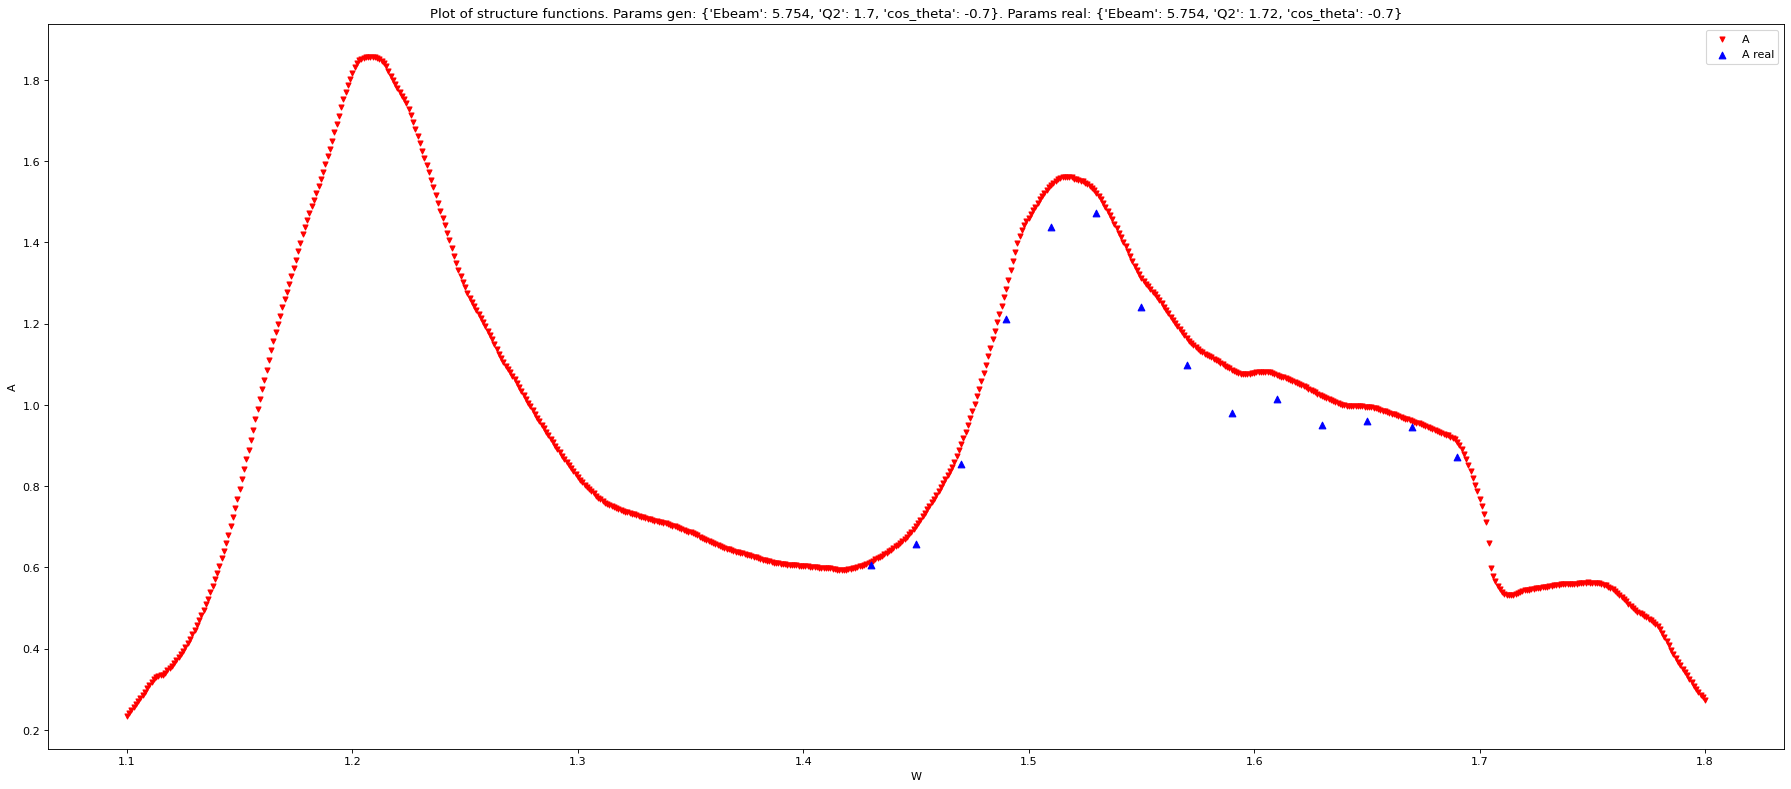

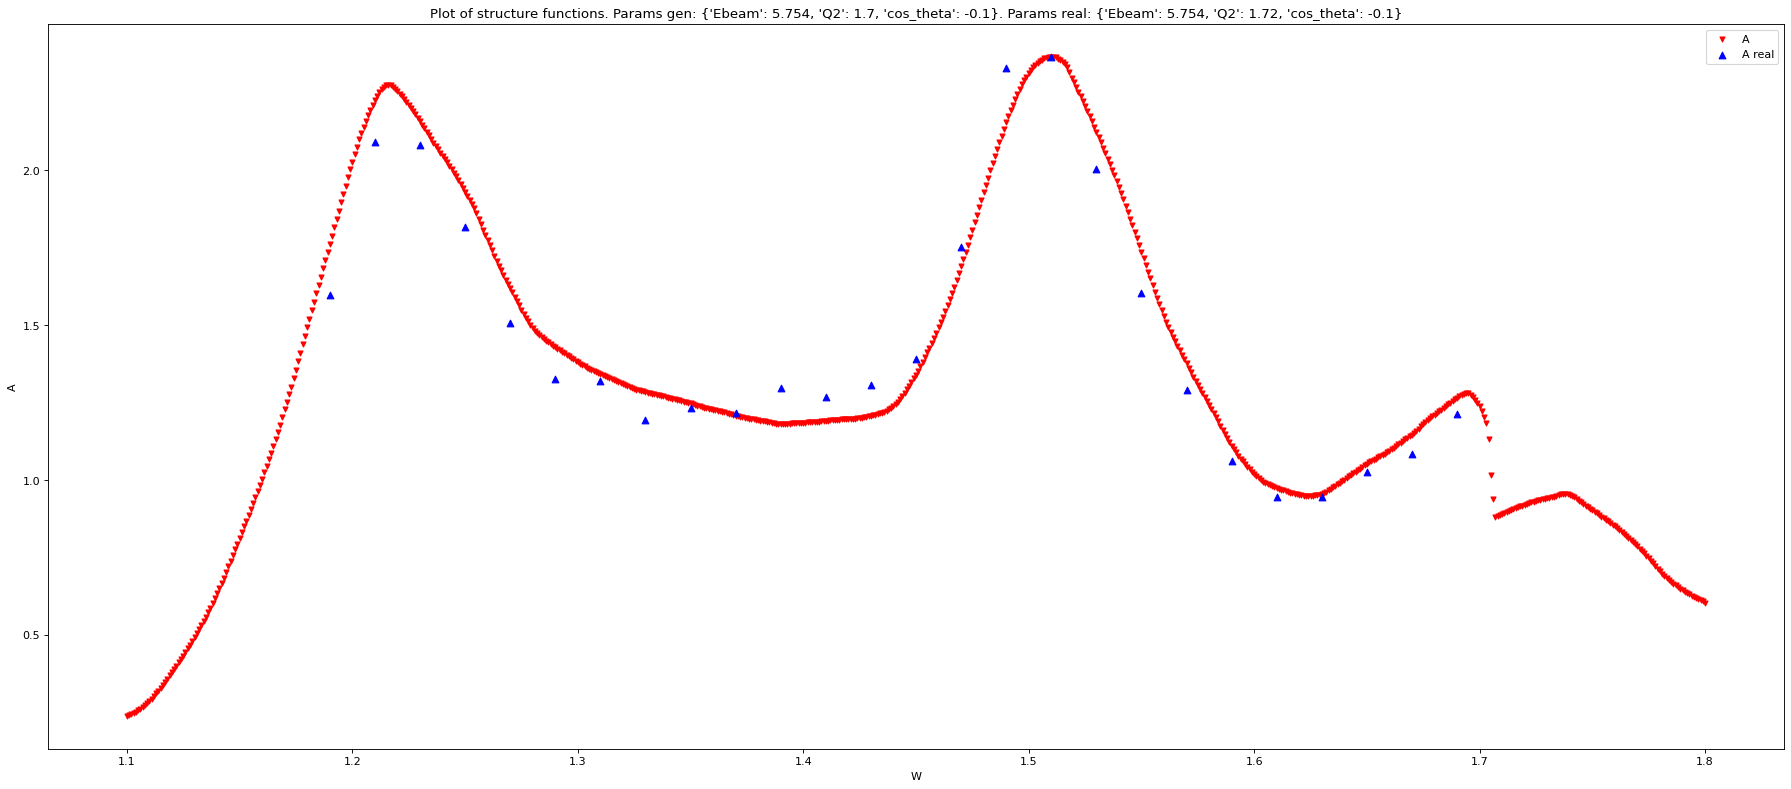

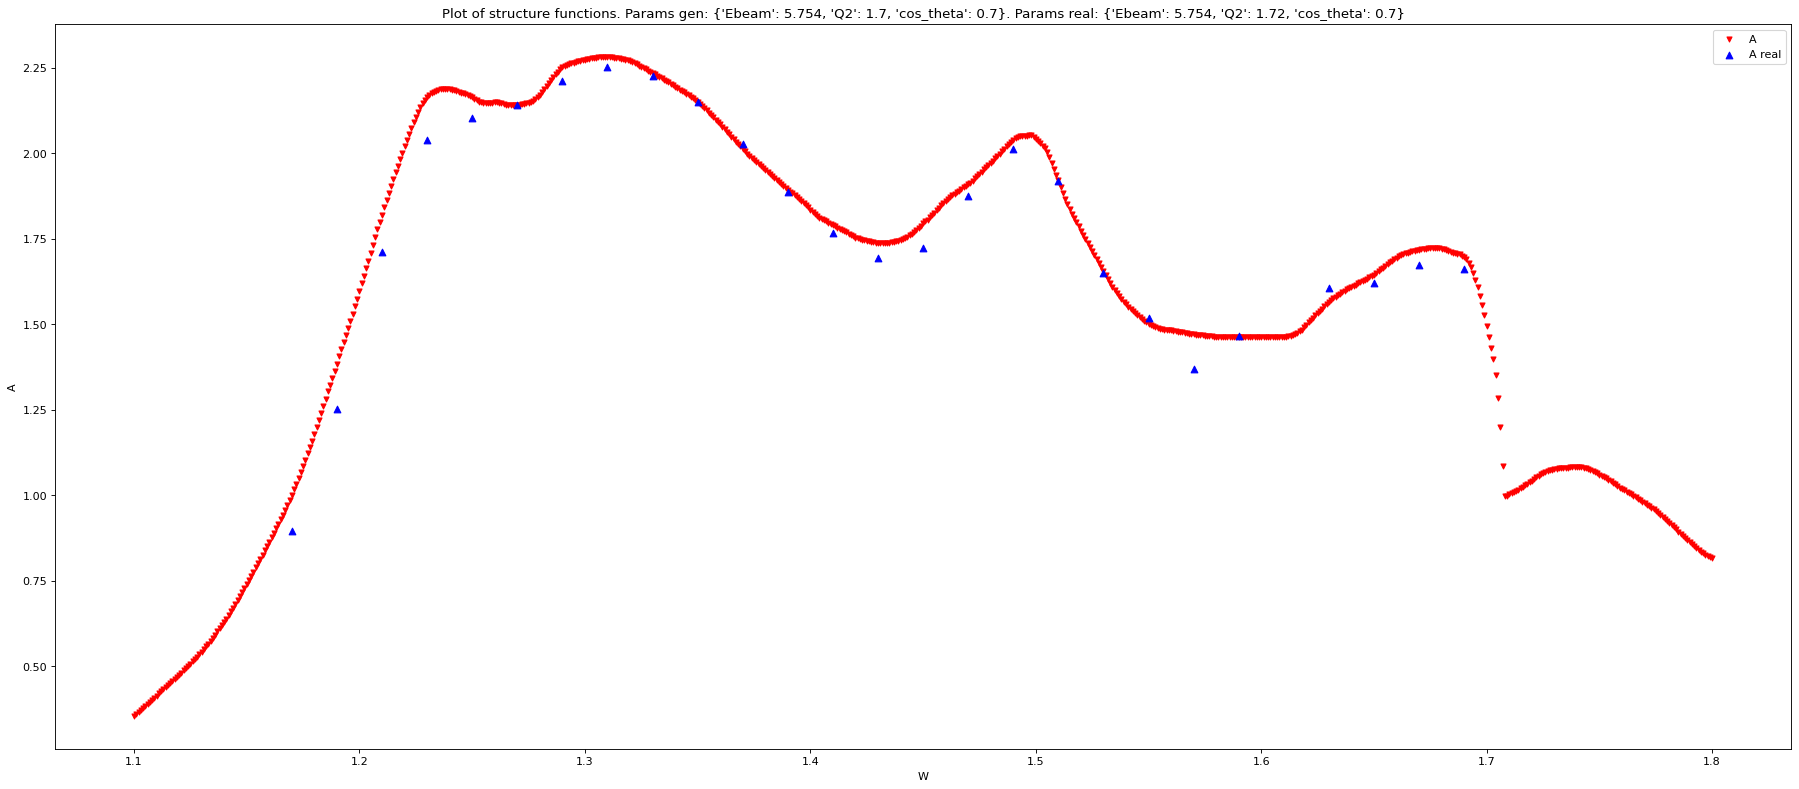

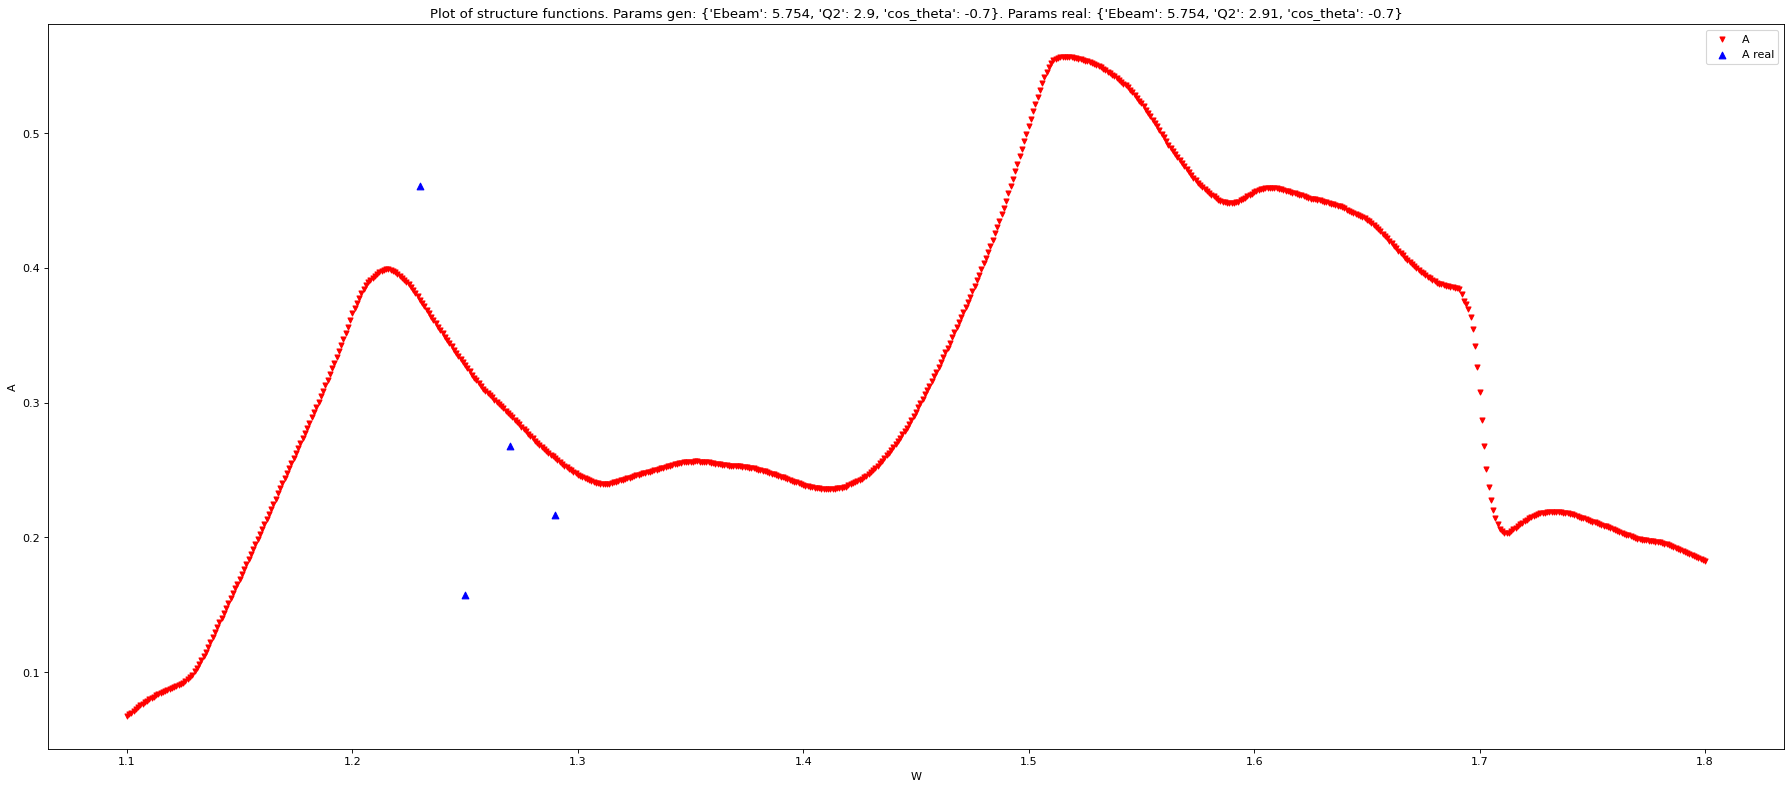

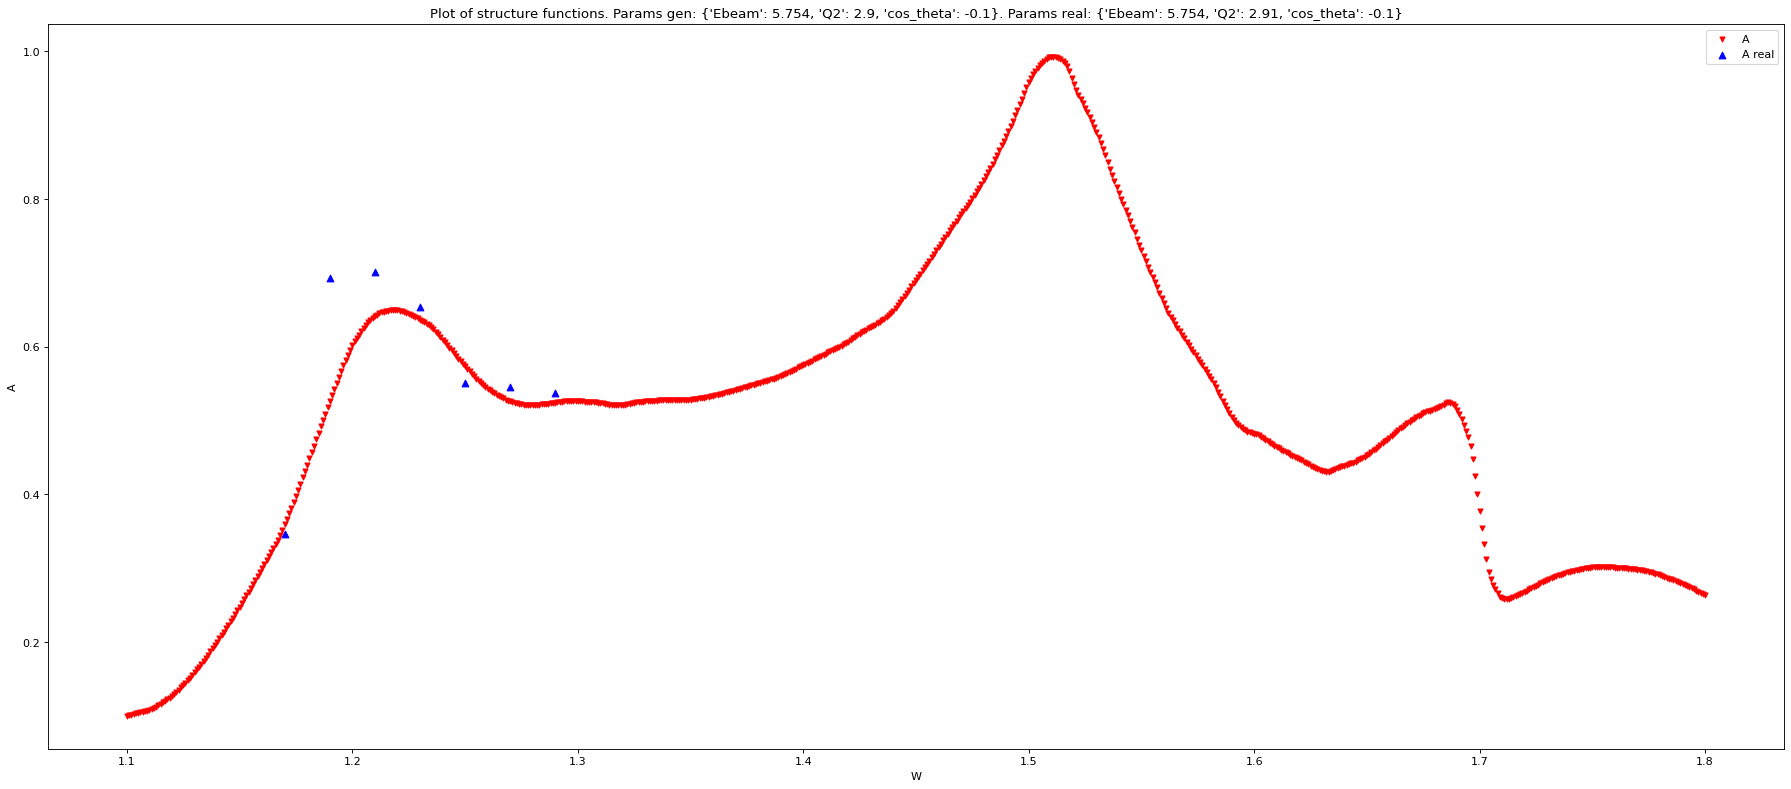

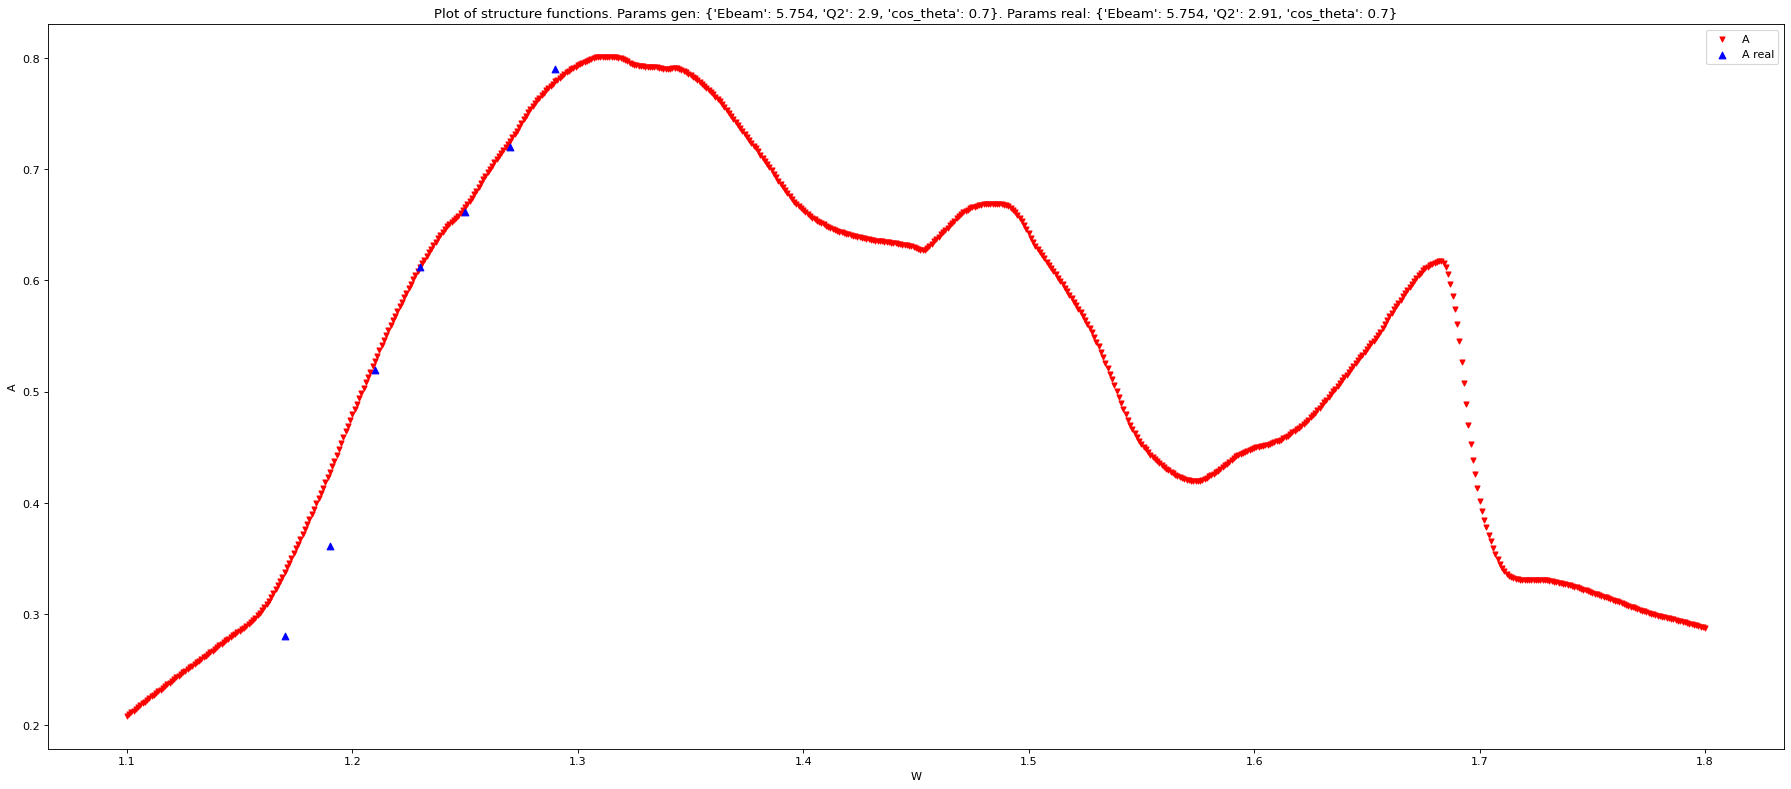

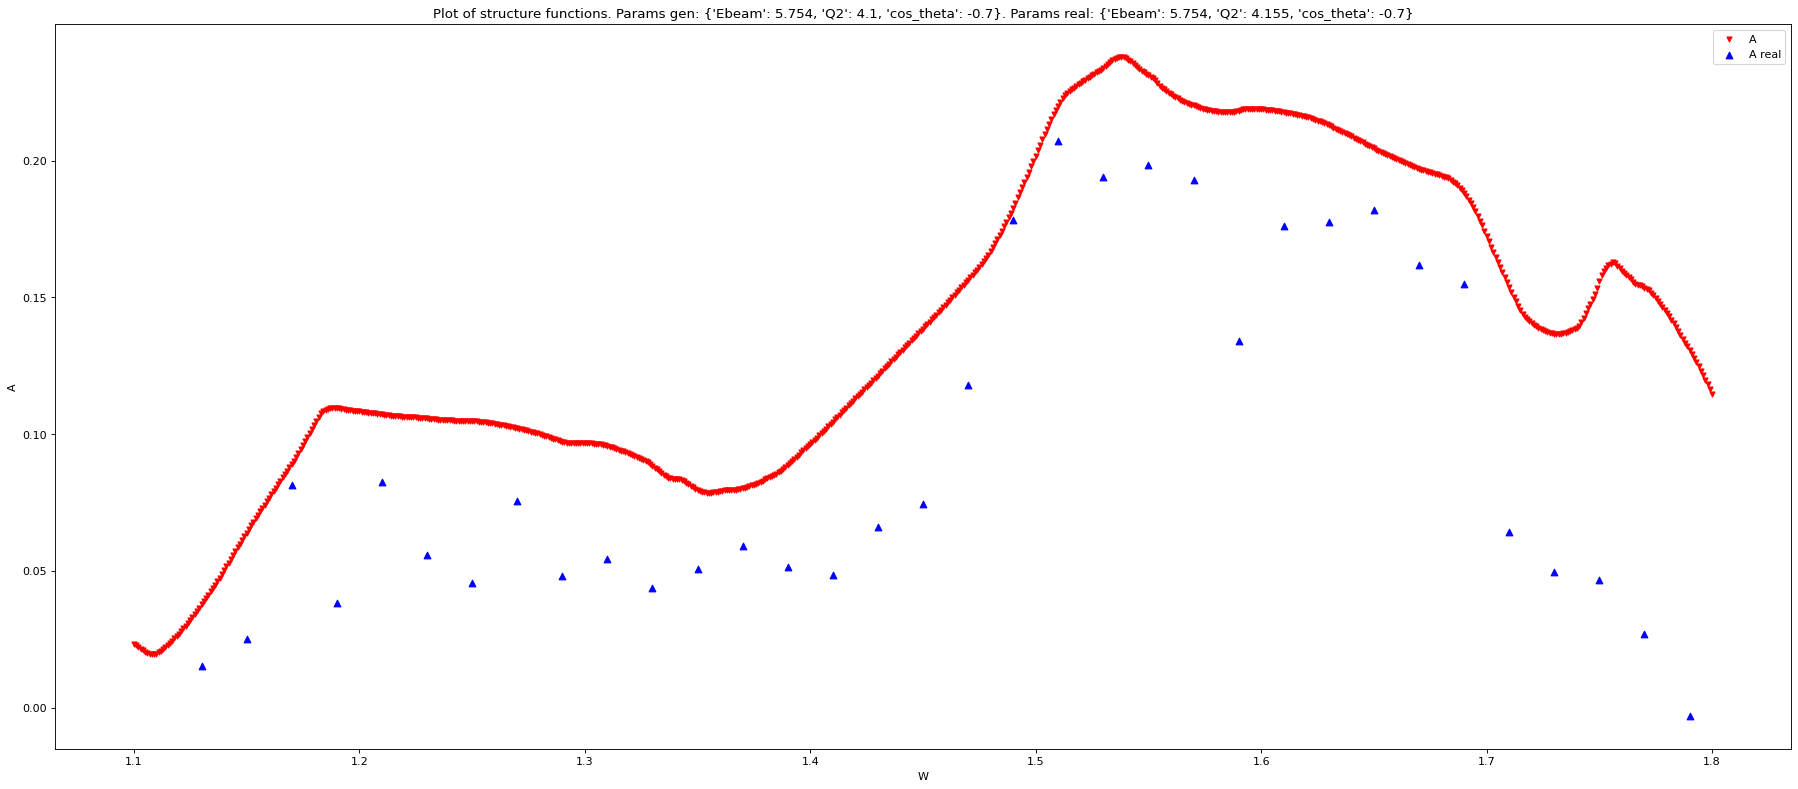

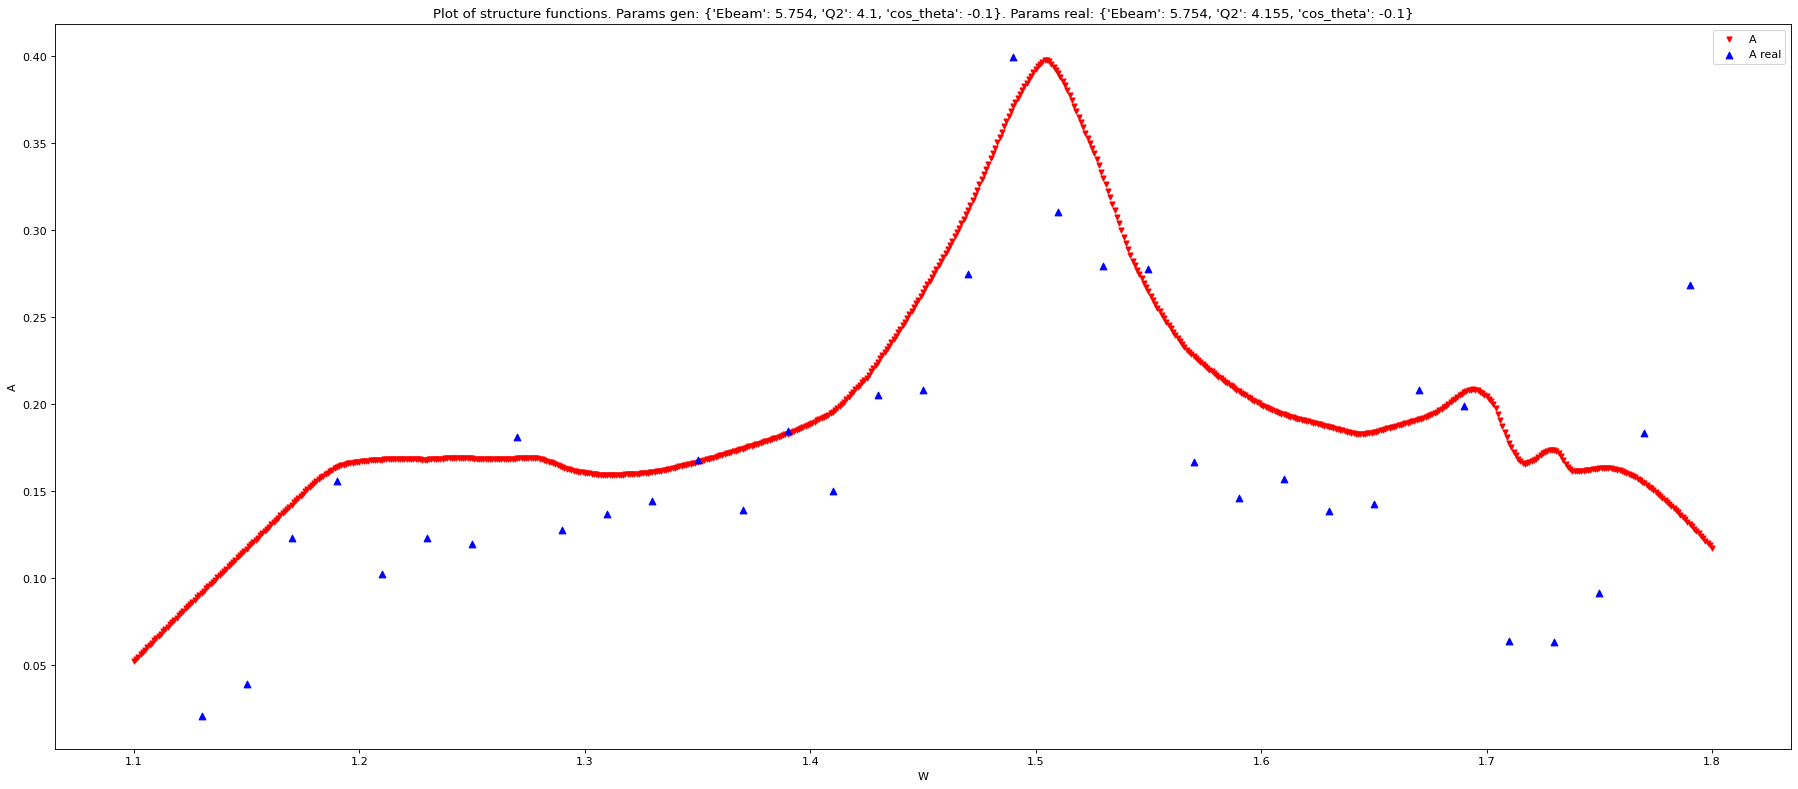

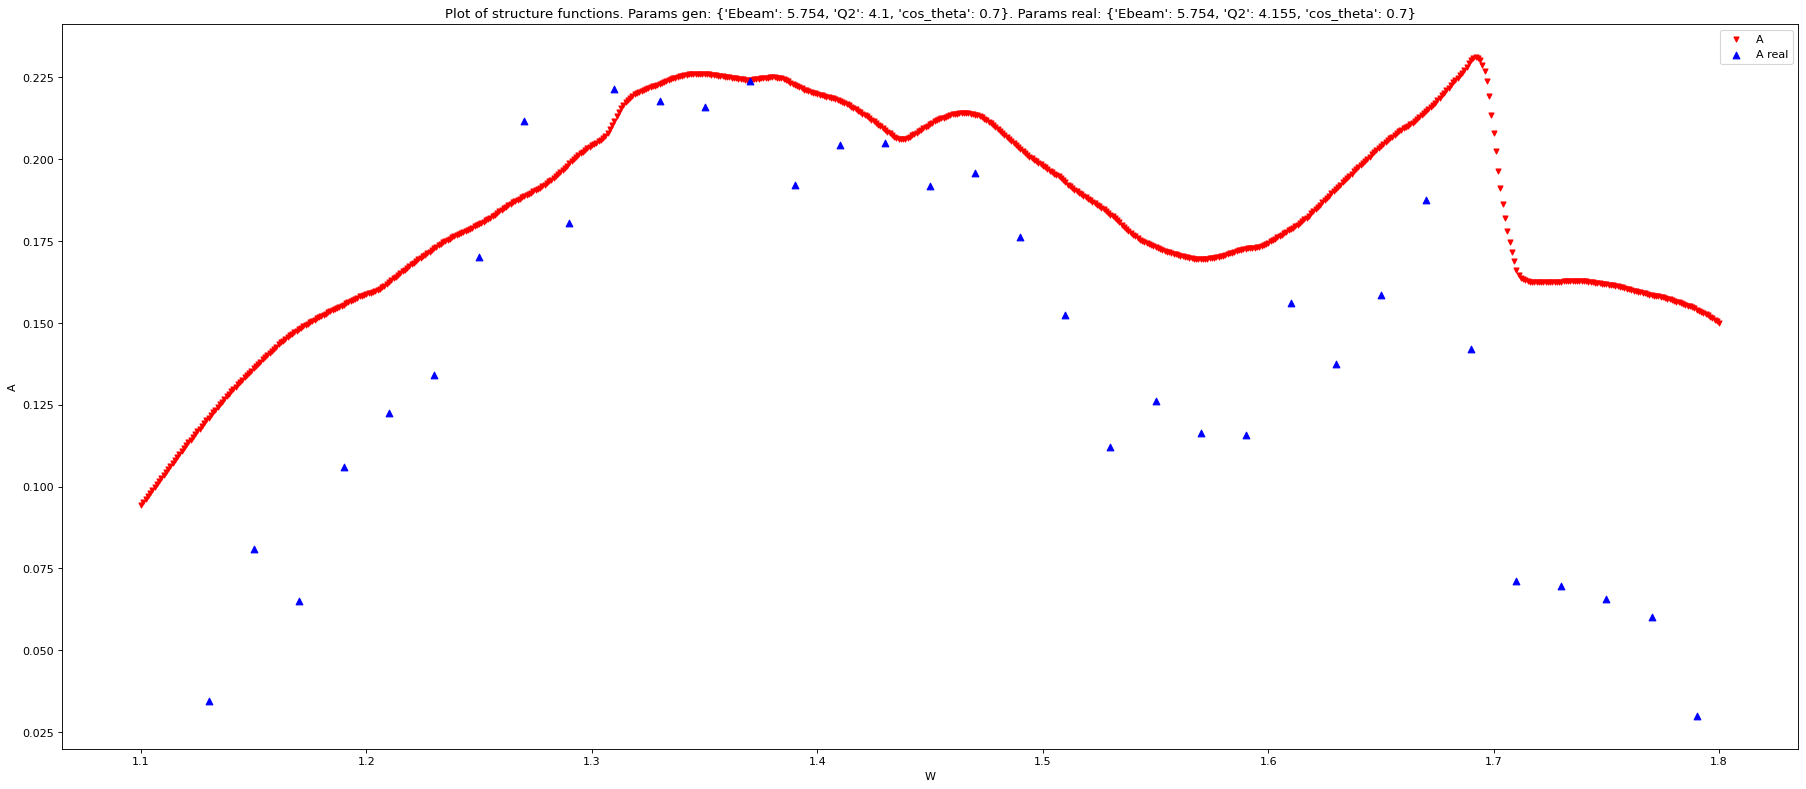

In [84]:
for i in range(3):
    for j in range(3):
        params_gen = {'Ebeam' : Ebeam,
                    'Q2' : Q2_gen[i],
                    'cos_theta' : cos_theta_gen[j]}

        params_real = {'Ebeam' : Ebeam,
                    'Q2' : Q2_real[i],
                    'cos_theta' : cos_theta_real[j]}
        plot_gen_real(params_gen, params_real)

# As a function of W for Ebeam = 5.499

In [40]:
Ebeam = 5.499
Q2_real = [1.8, 2.6, 3.15]
Q2_gen = [1.8, 2.6, 3.1]

cos_theta_gen = cos_theta_real = [-0.7, -0.1, 0.7]

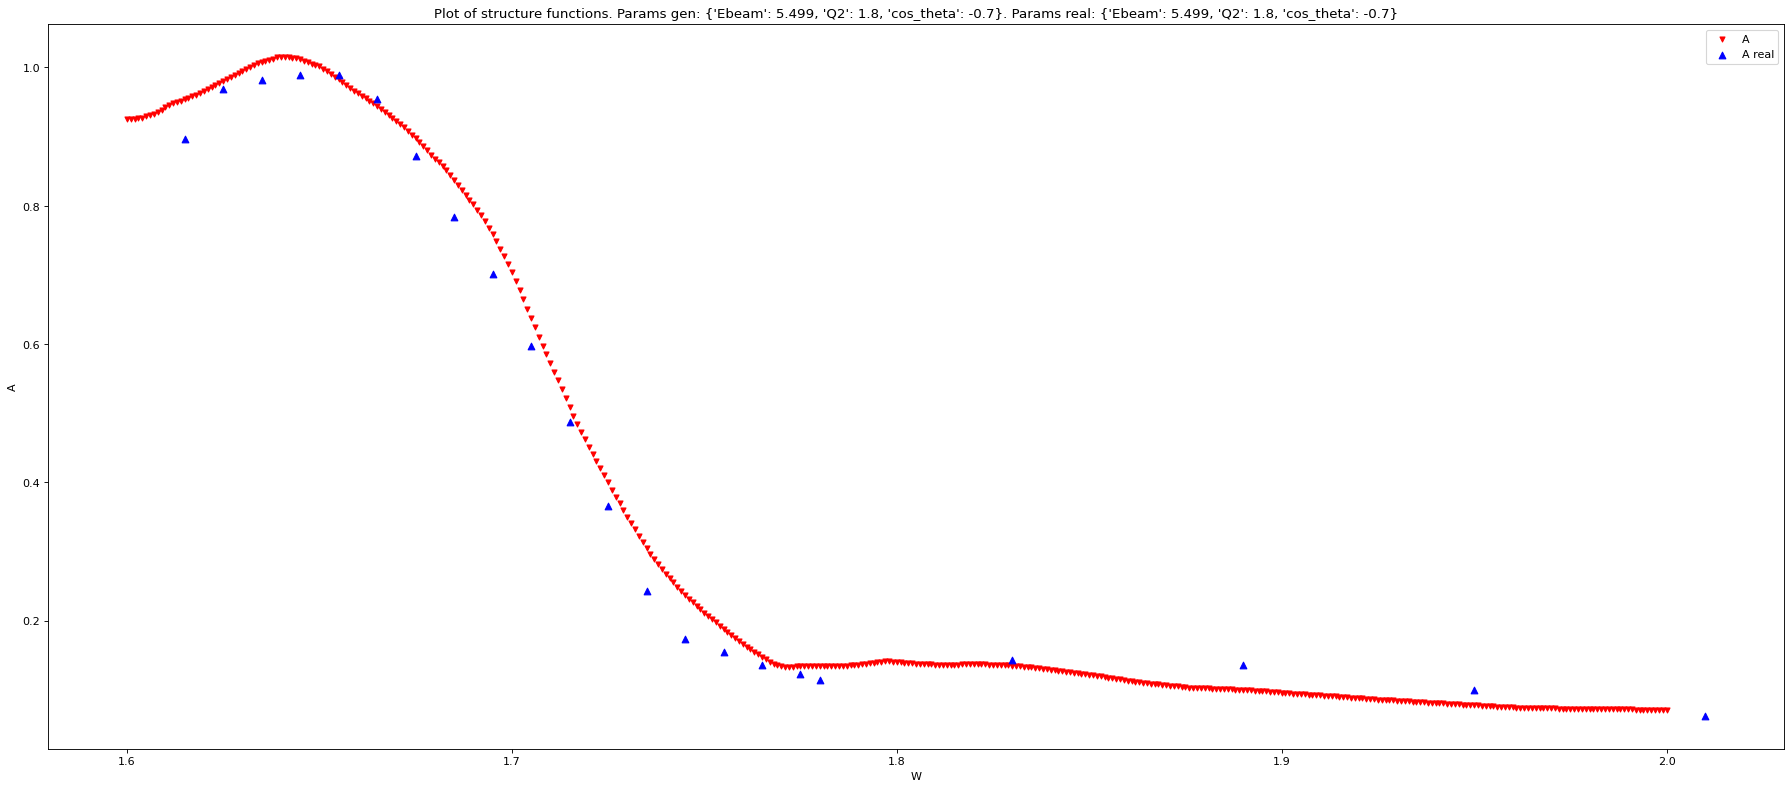

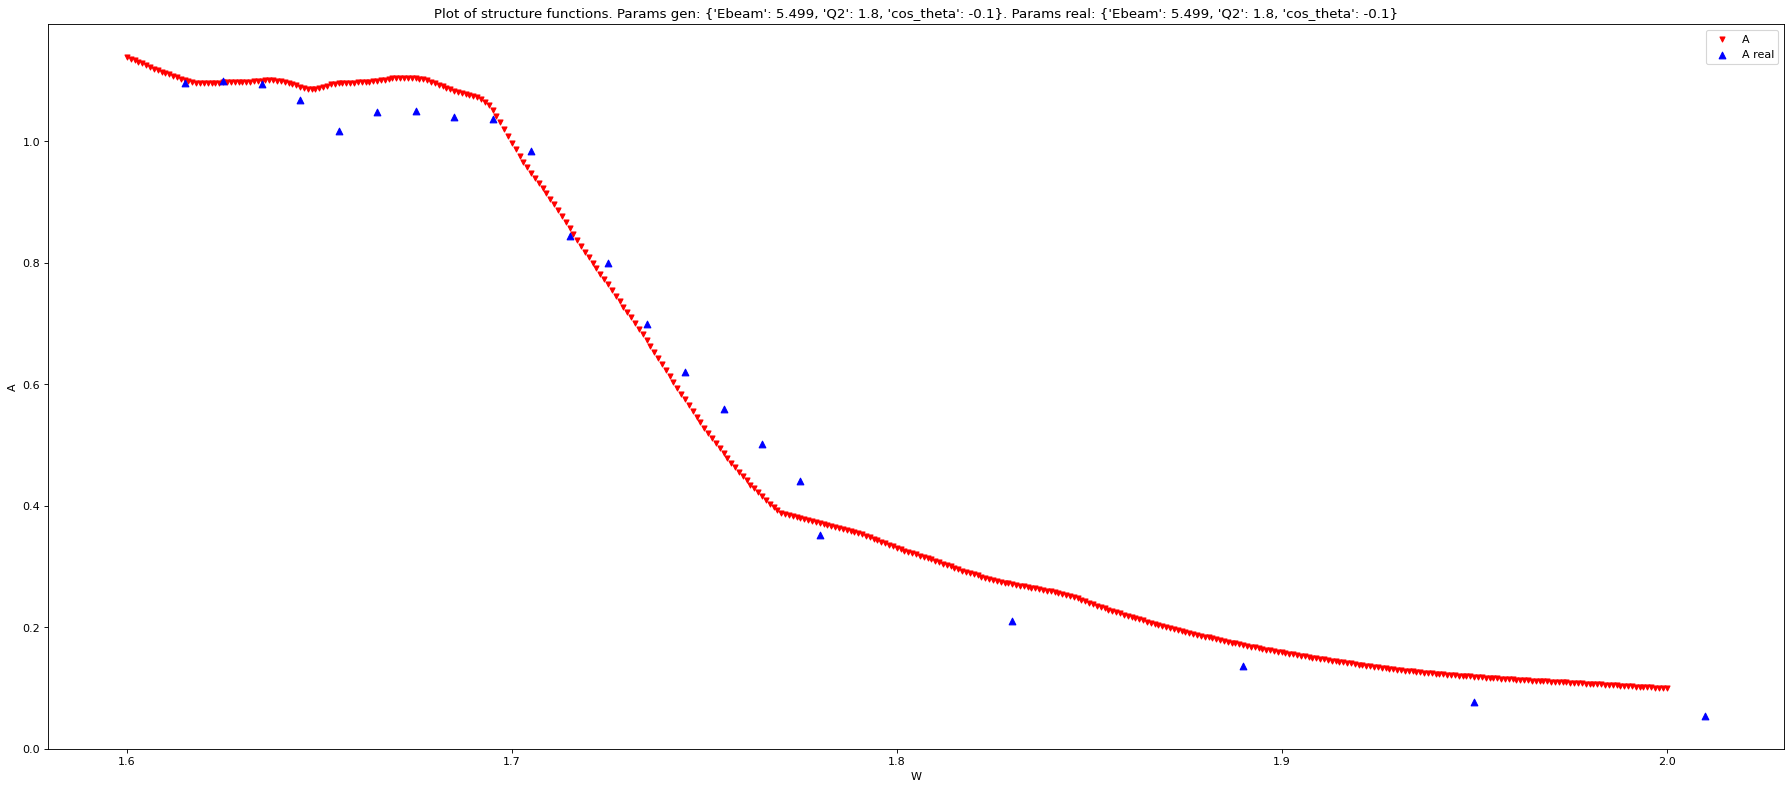

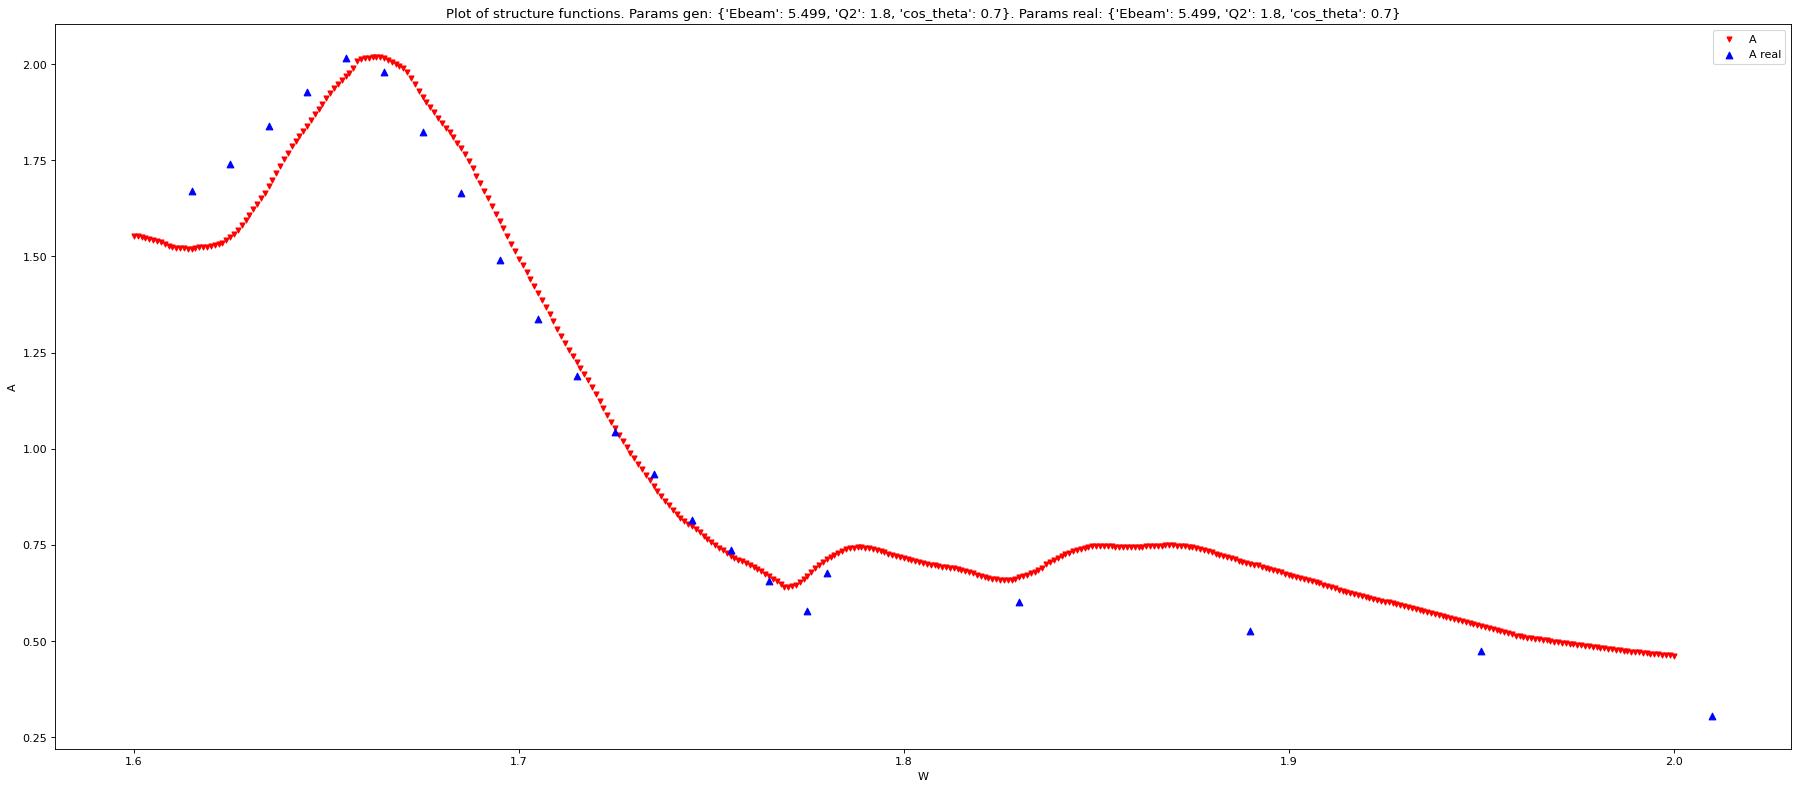

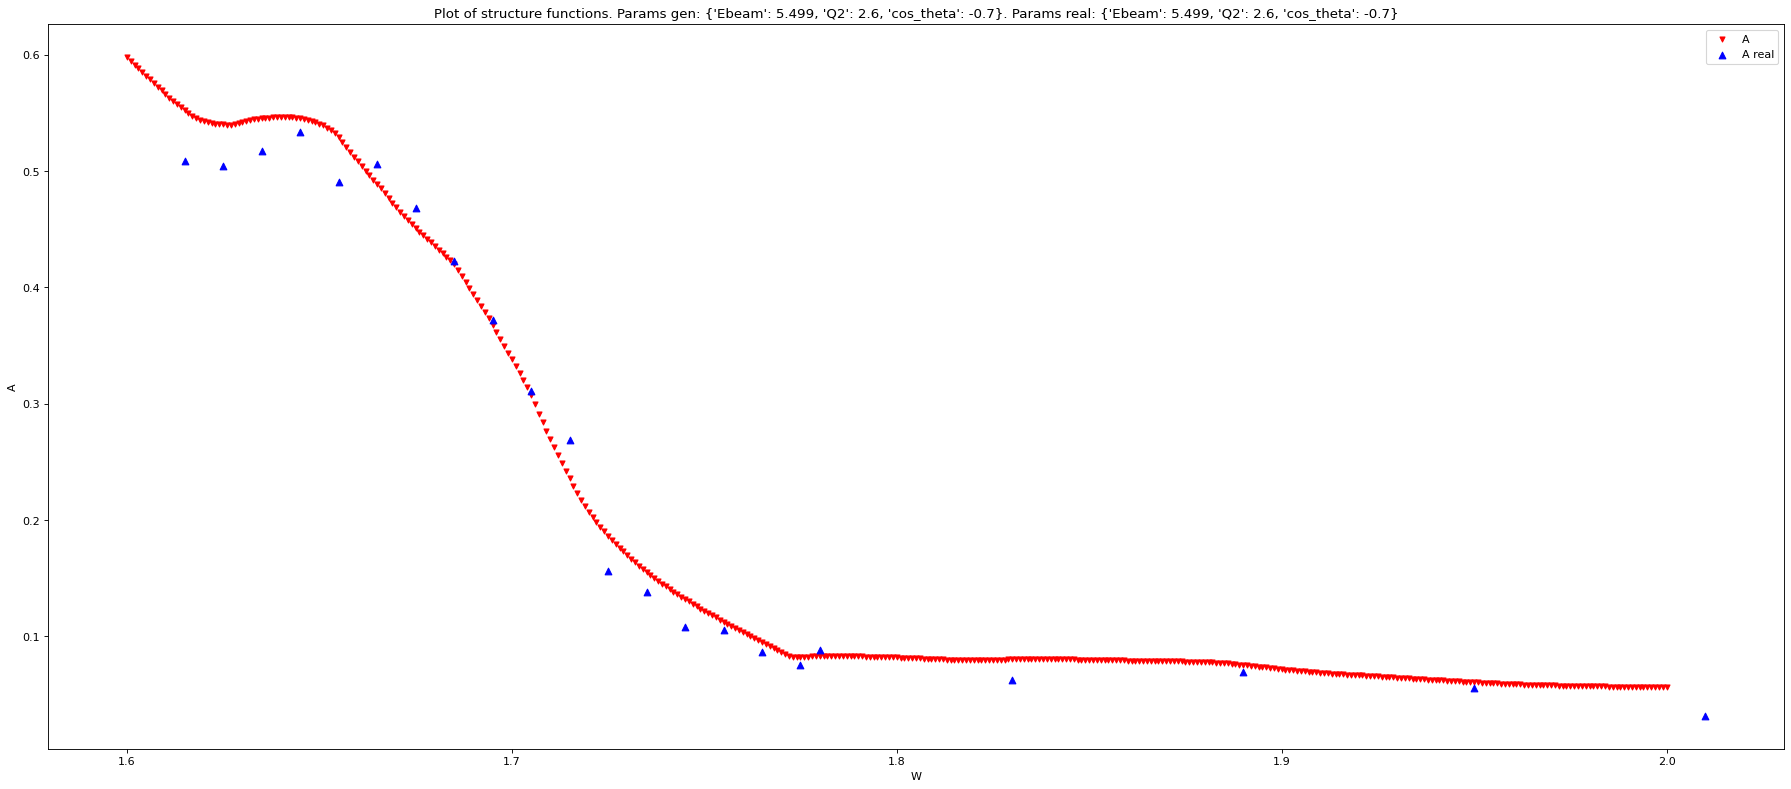

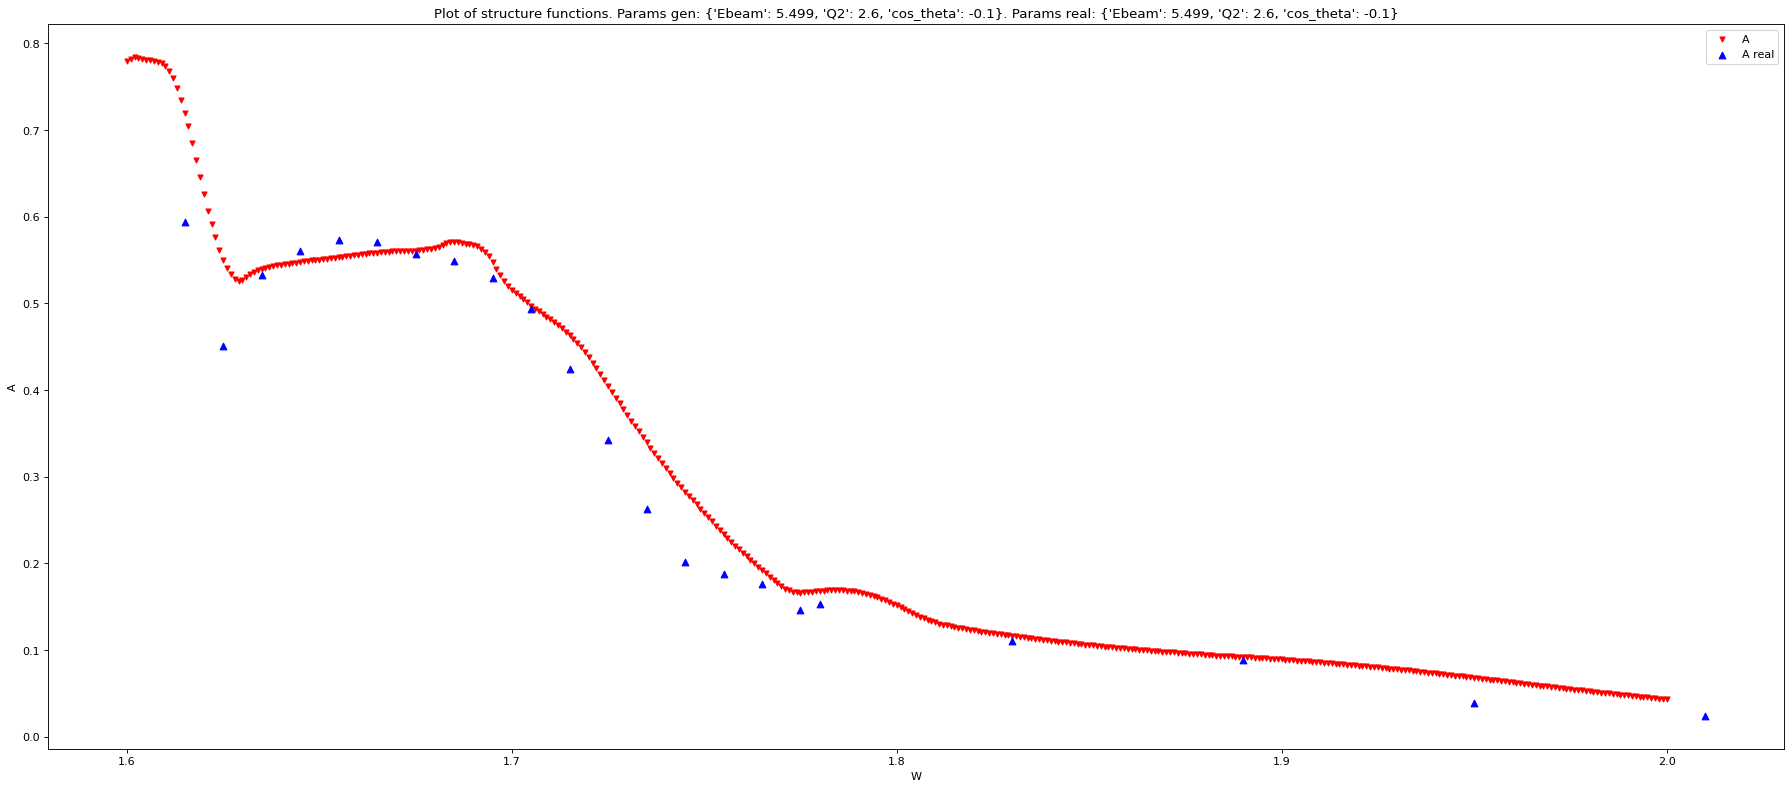

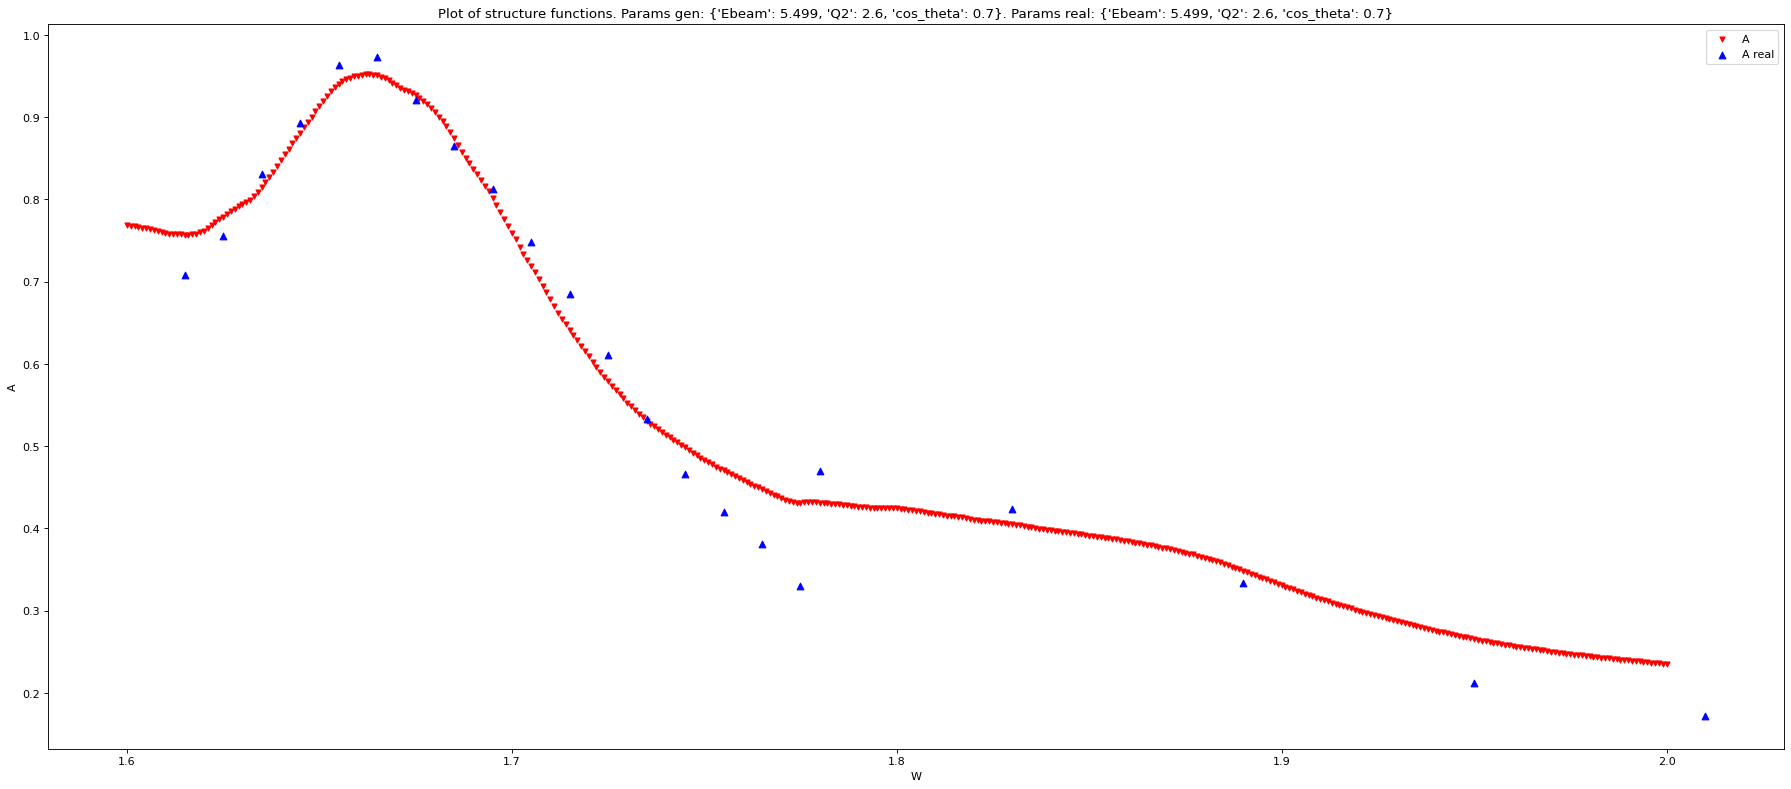

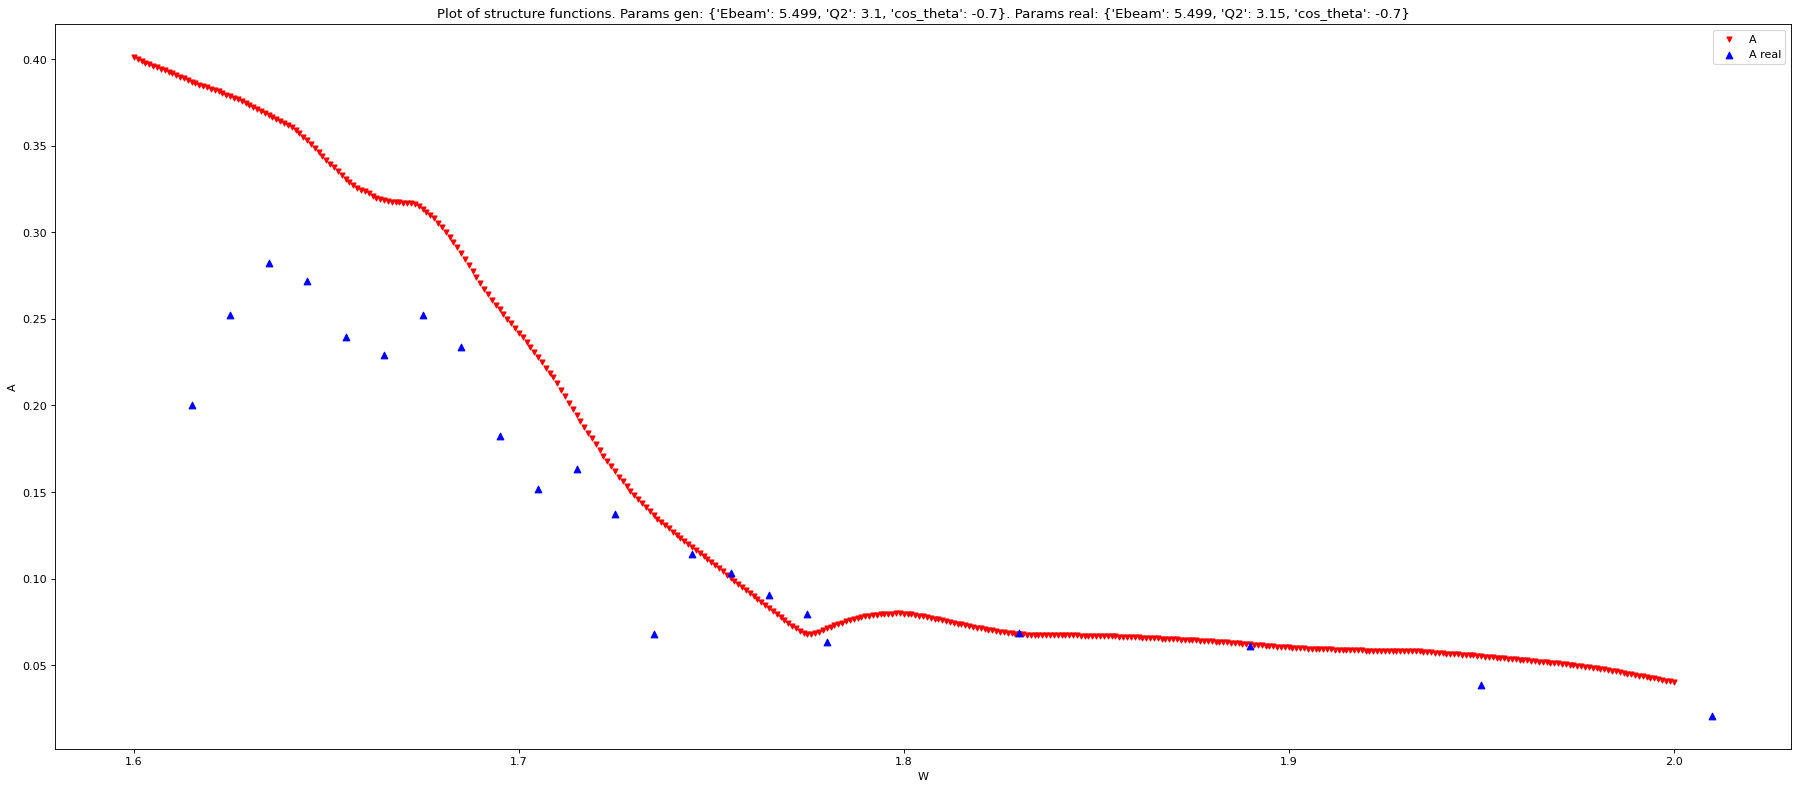

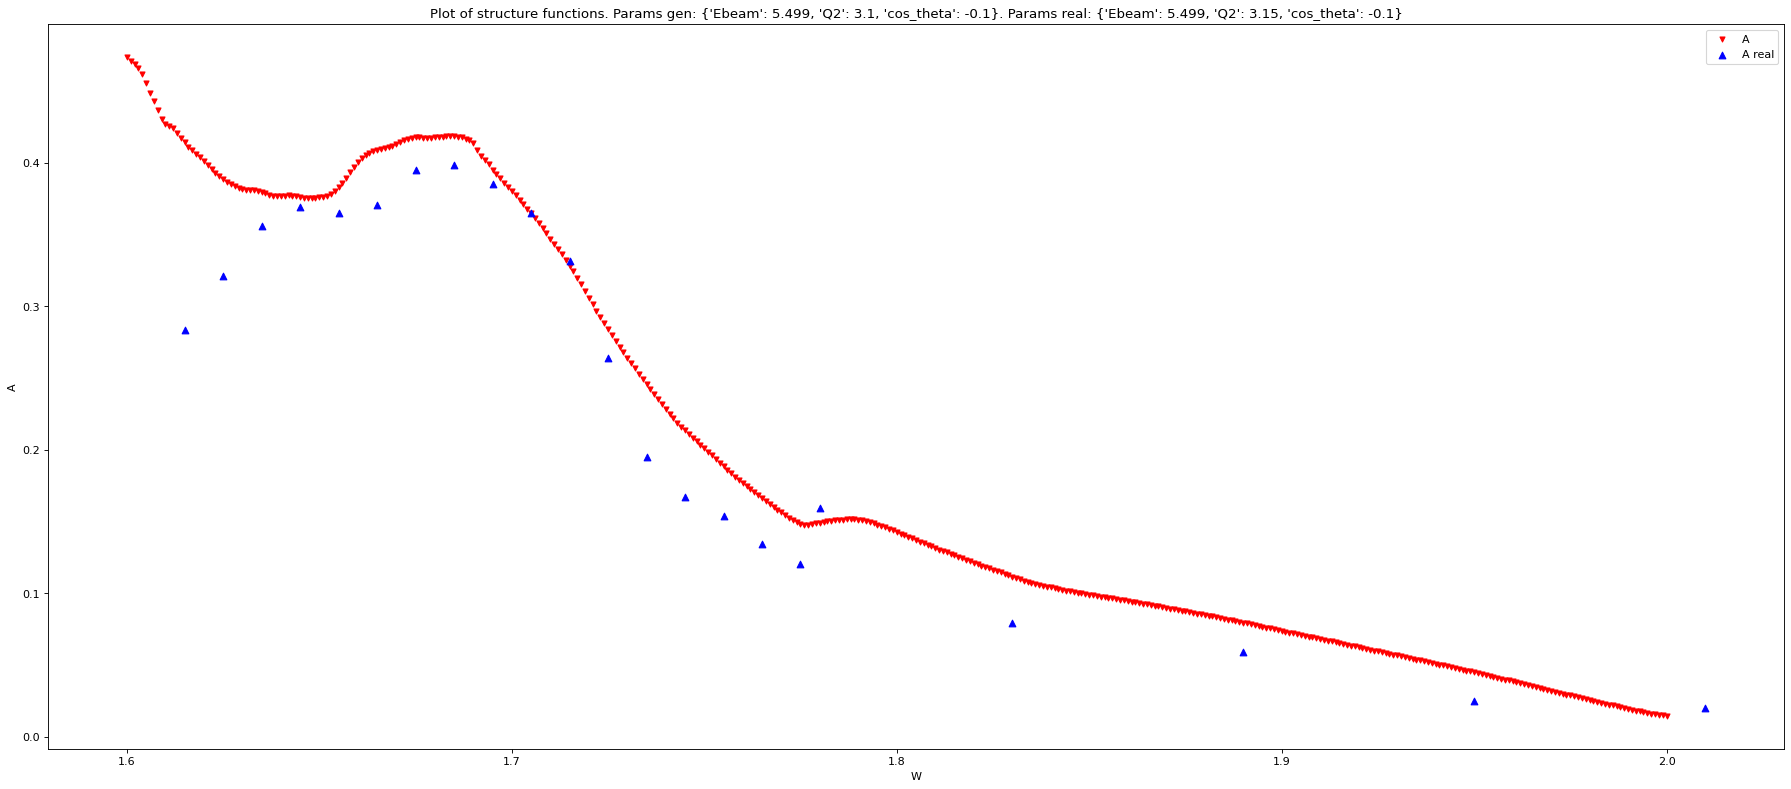

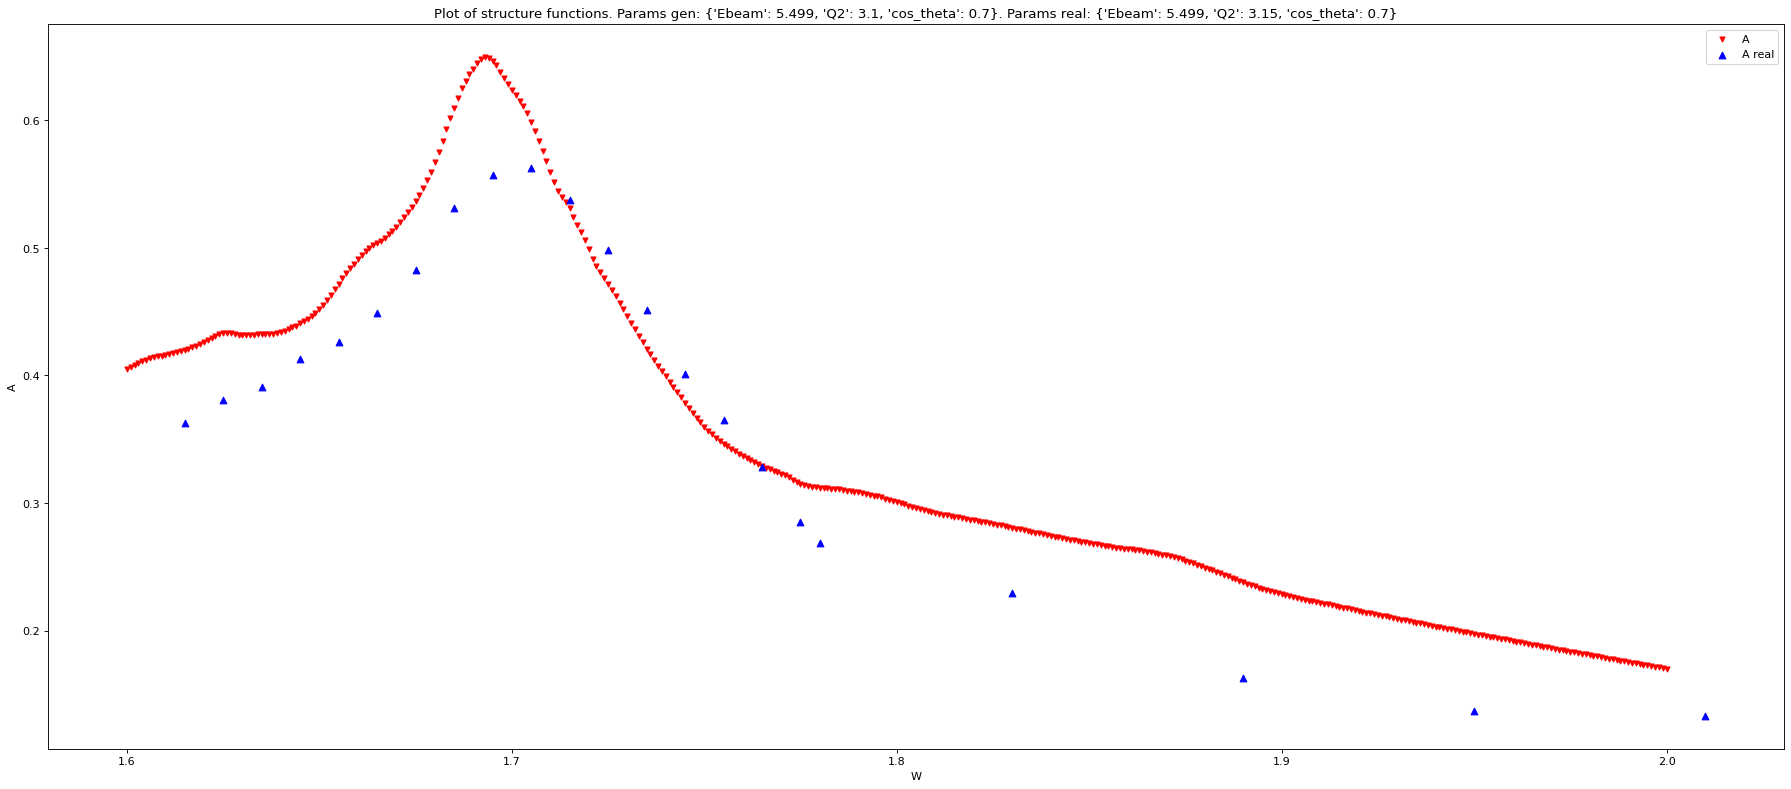

In [54]:
for i in range(3):
    for j in range(3):
        params_gen = {'Ebeam' : Ebeam,
                    'Q2' : Q2_gen[i],
                    'cos_theta' : cos_theta_gen[j]}

        params_real = {'Ebeam' : Ebeam,
                    'Q2' : Q2_real[i],
                    'cos_theta' : cos_theta_real[j]}
        plot_gen_real(params_gen, params_real)

# Now with data from Almaz's website

In [21]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (25, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [120]:
Ebeam = 5.754
Q2_gen = [1.7, 2.9, 4.1]
Q2_real = [1.72, 2.91, 4.16]

cos_theta_gen = cos_theta_real = [-0.7, -0.1, 0.7]

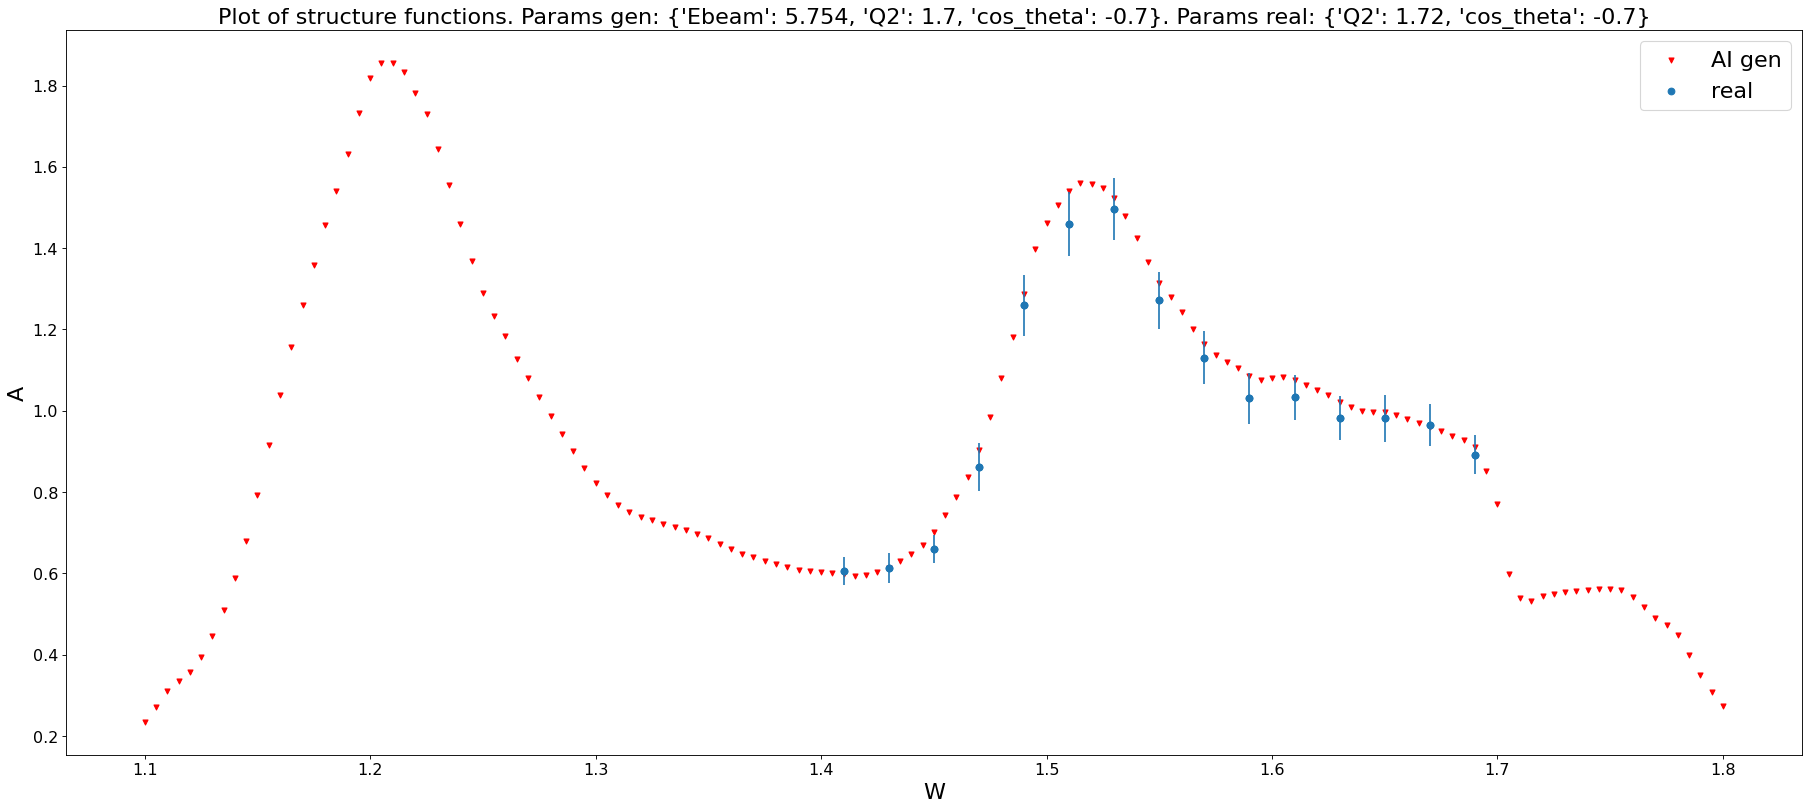

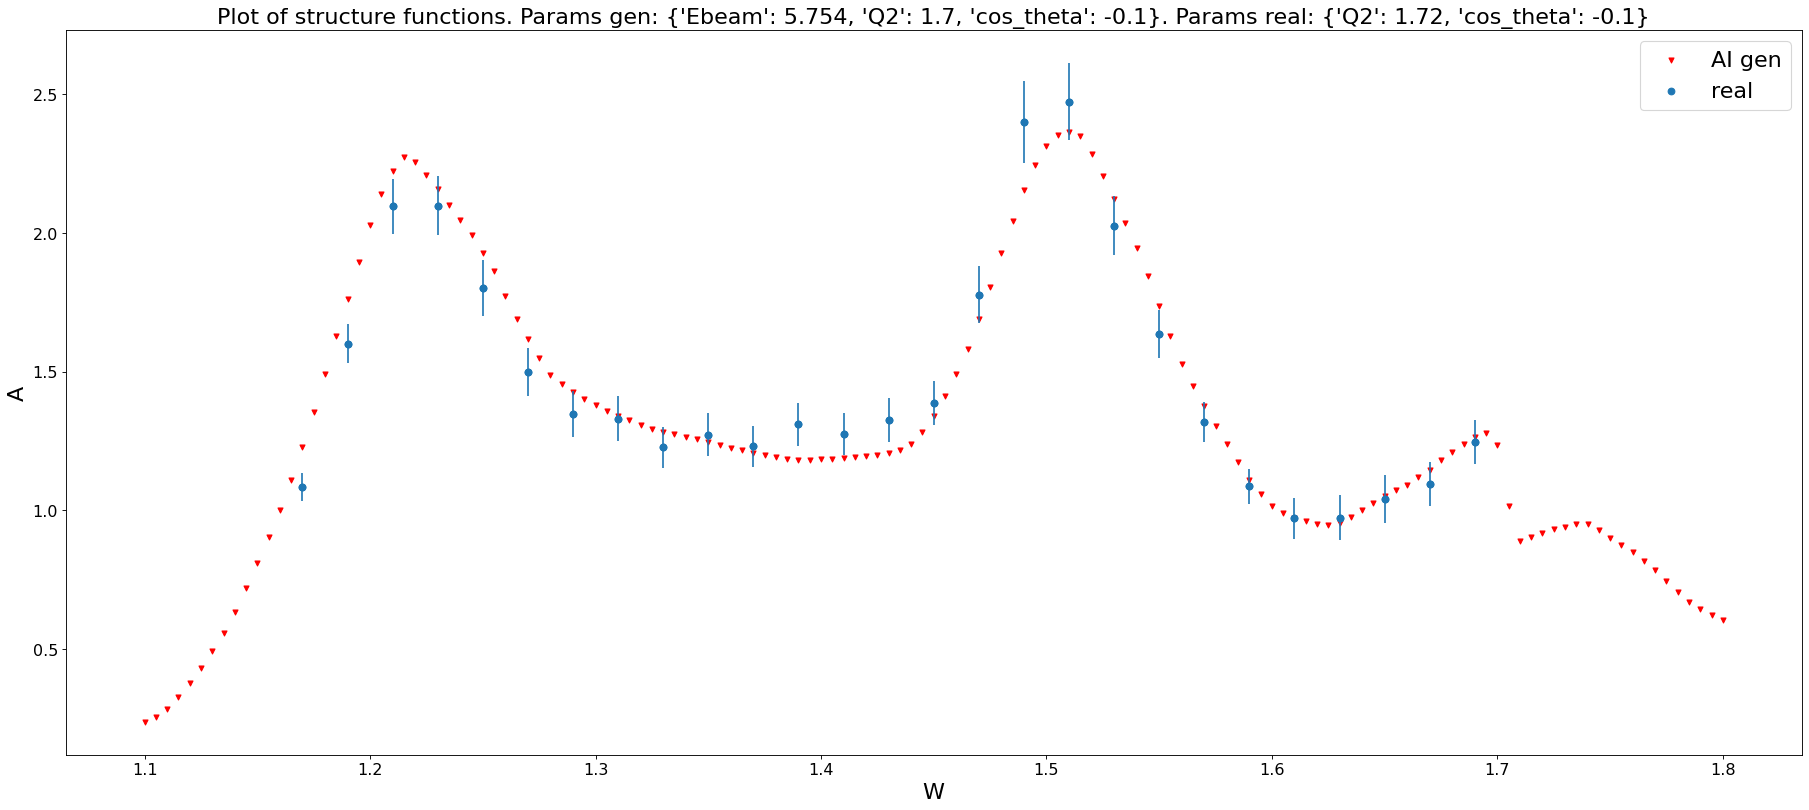

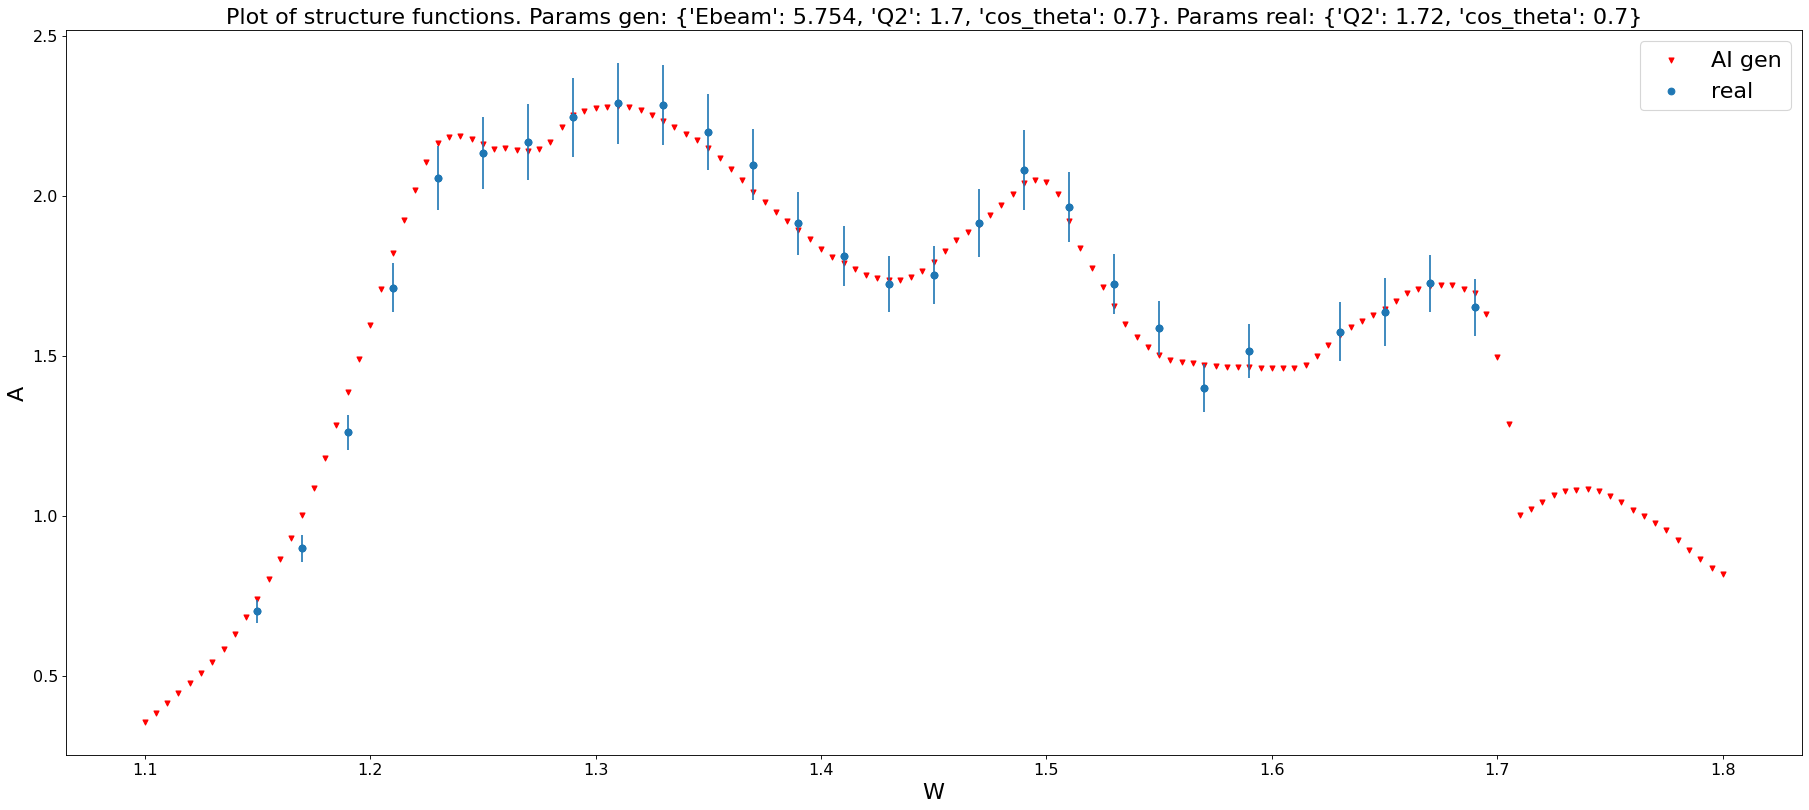

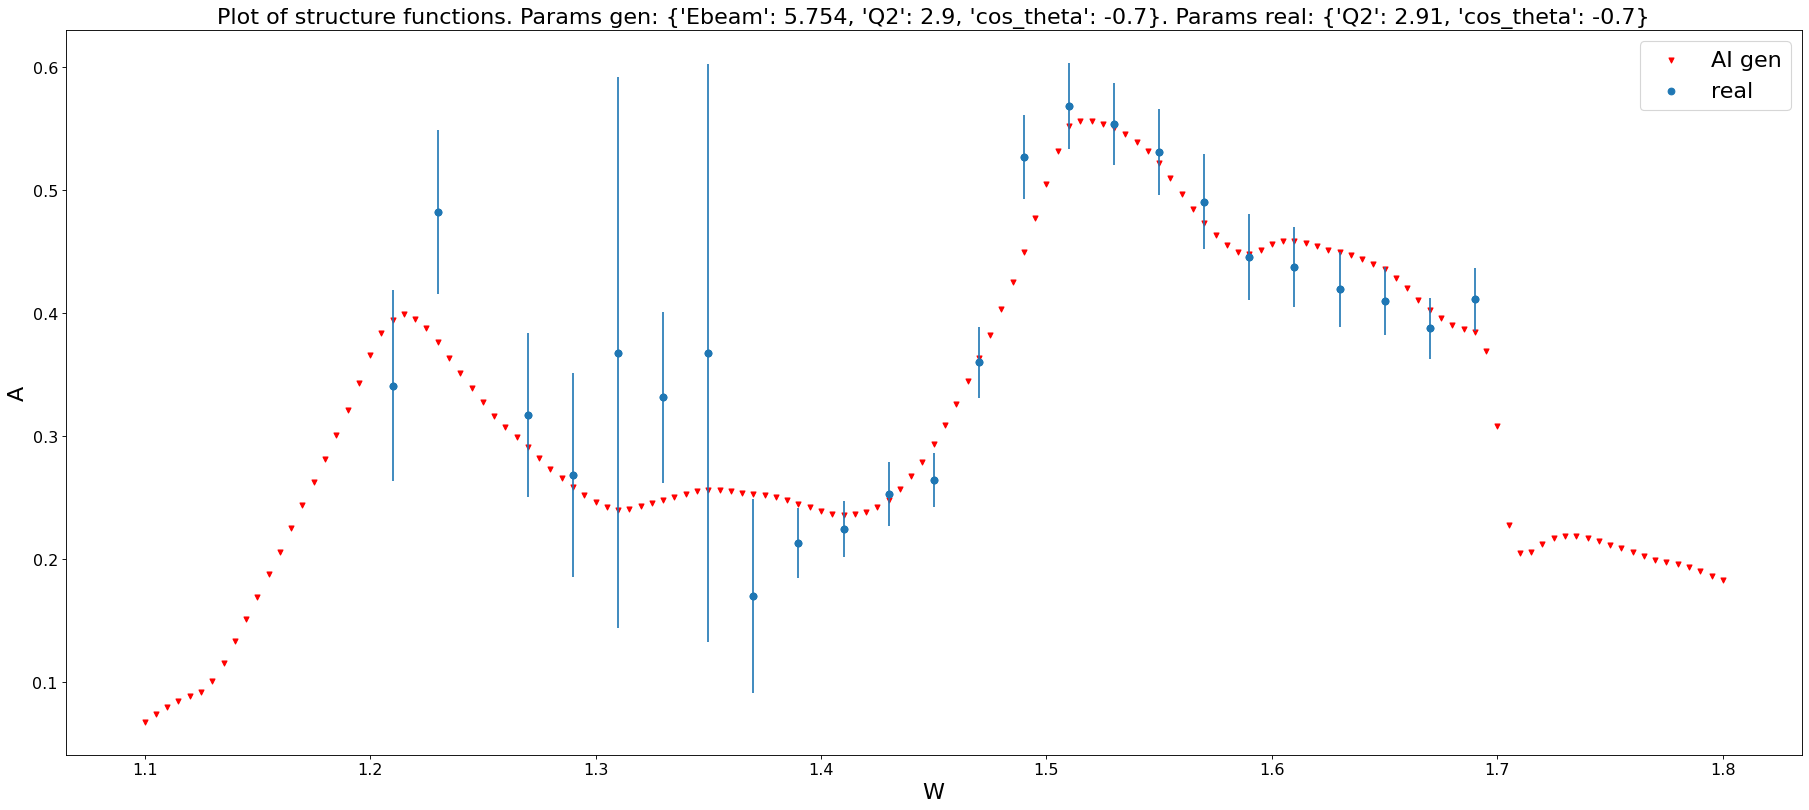

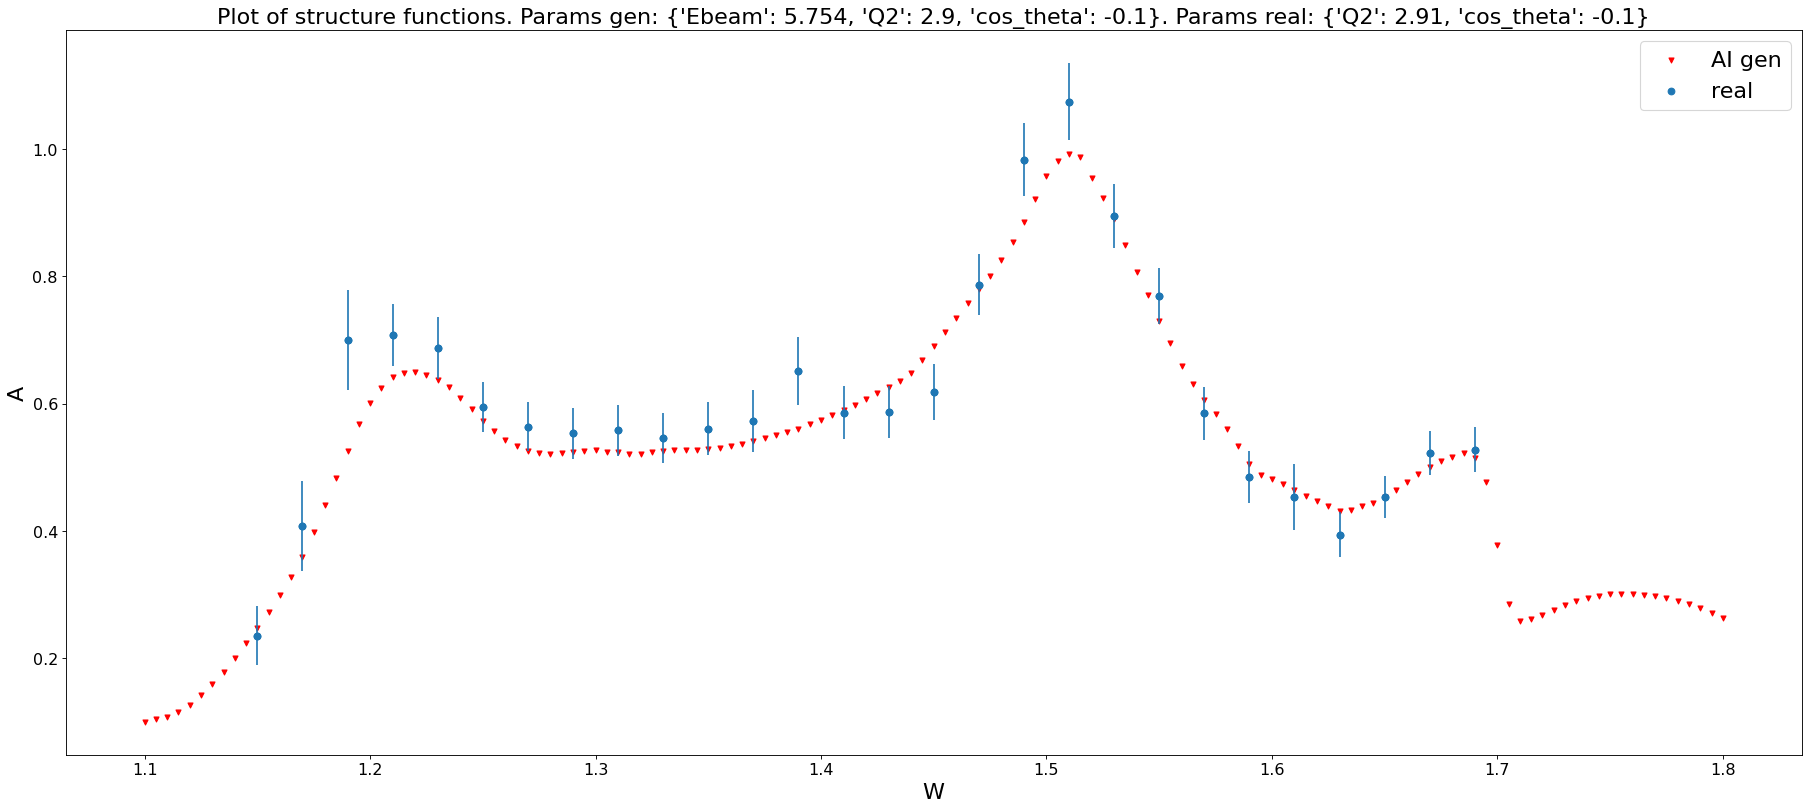

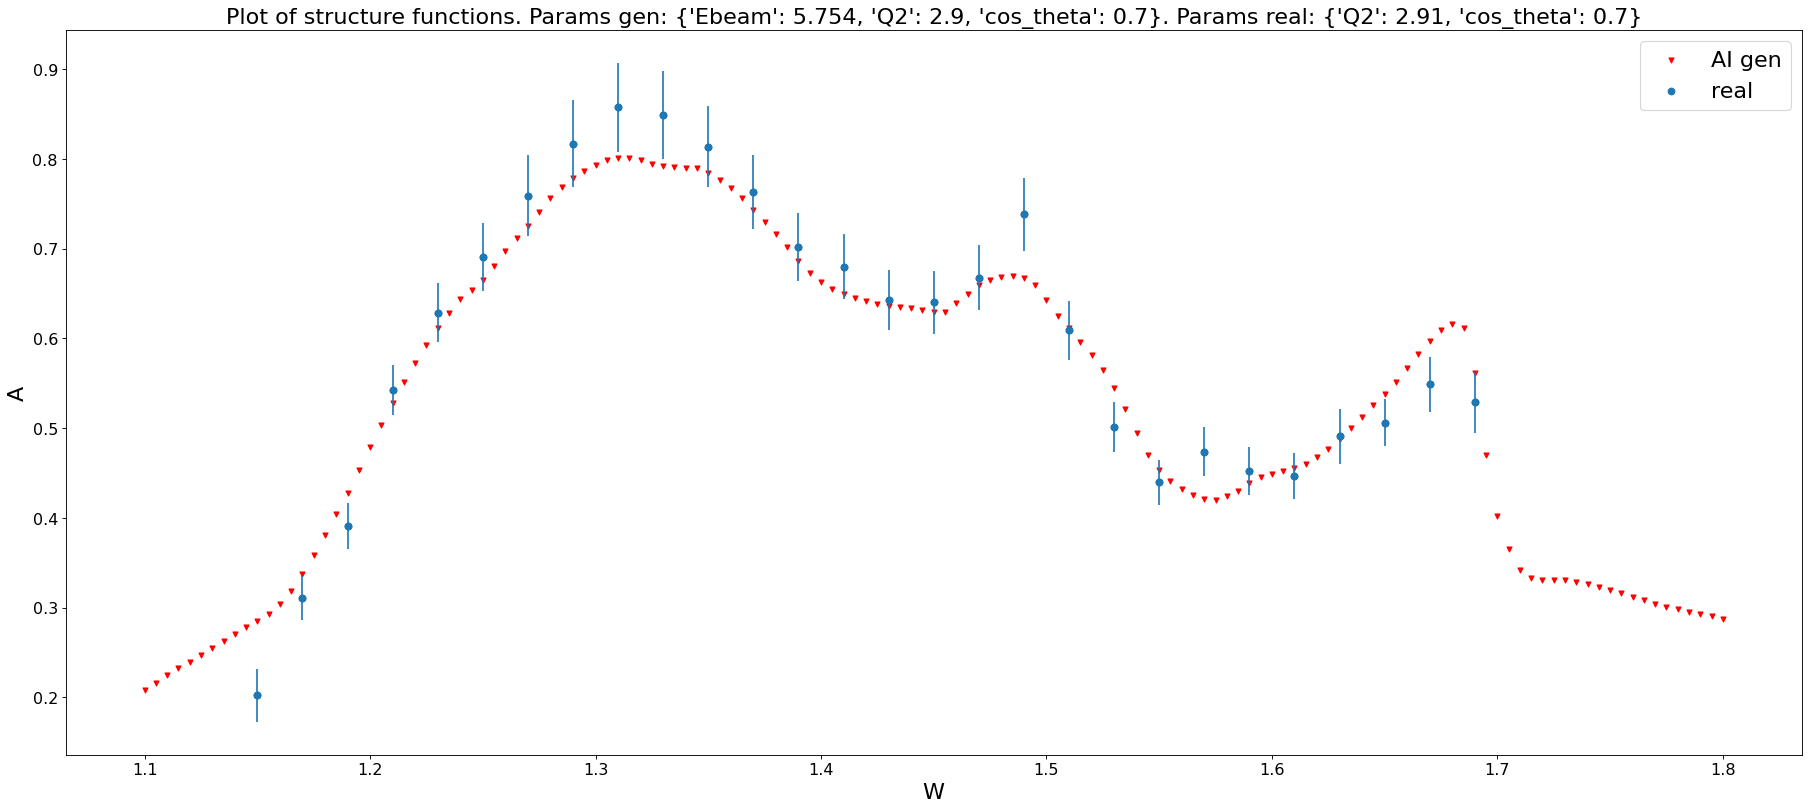

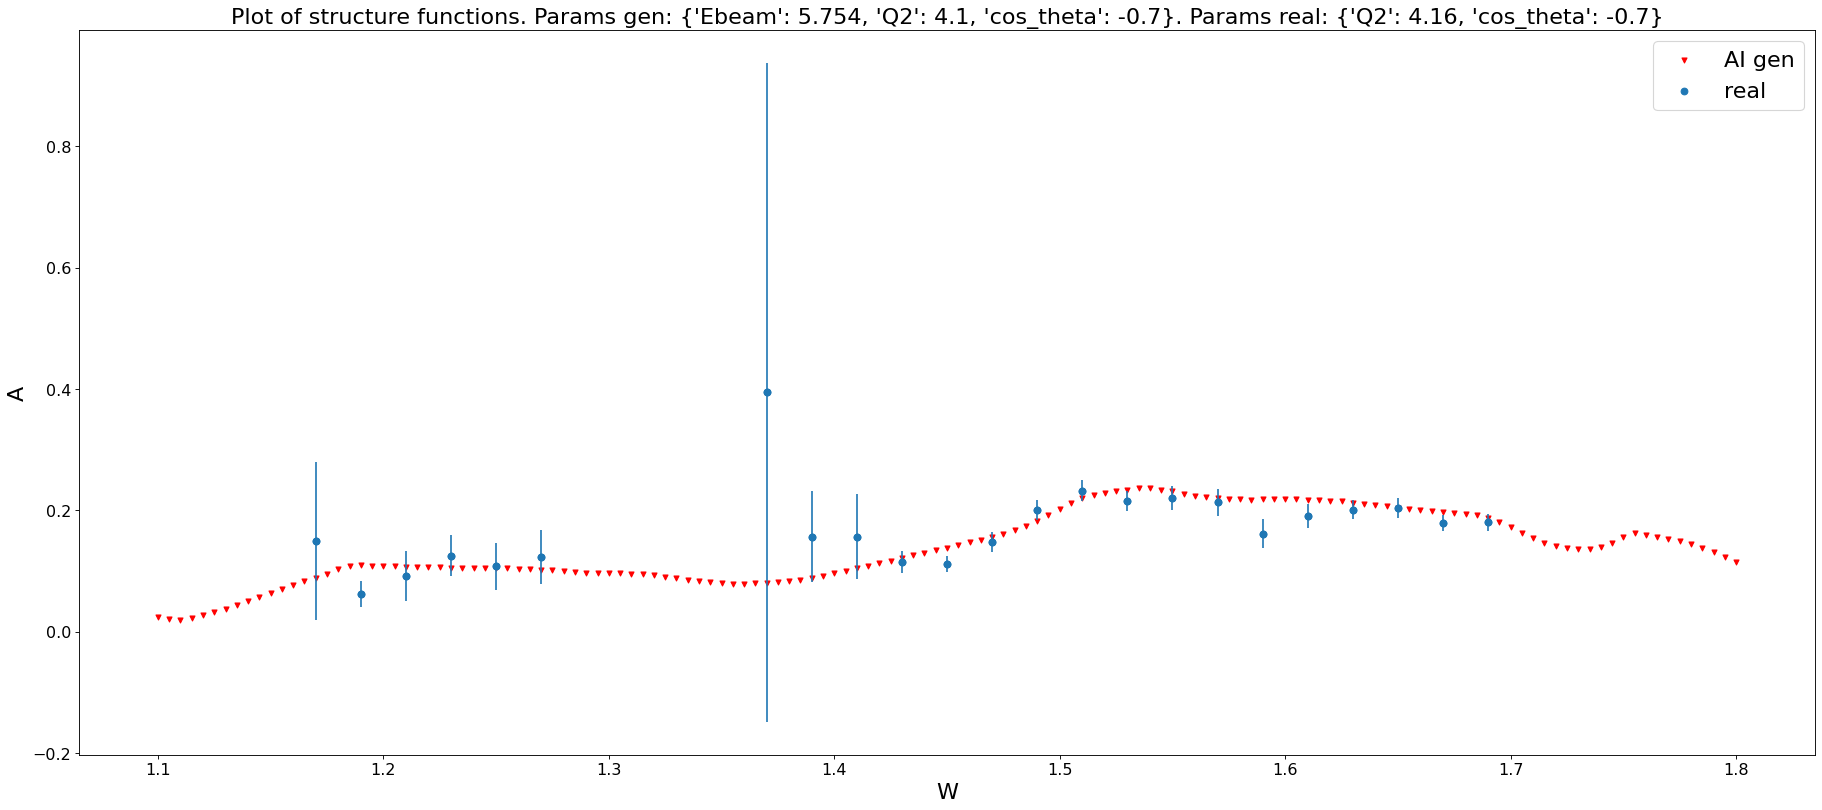

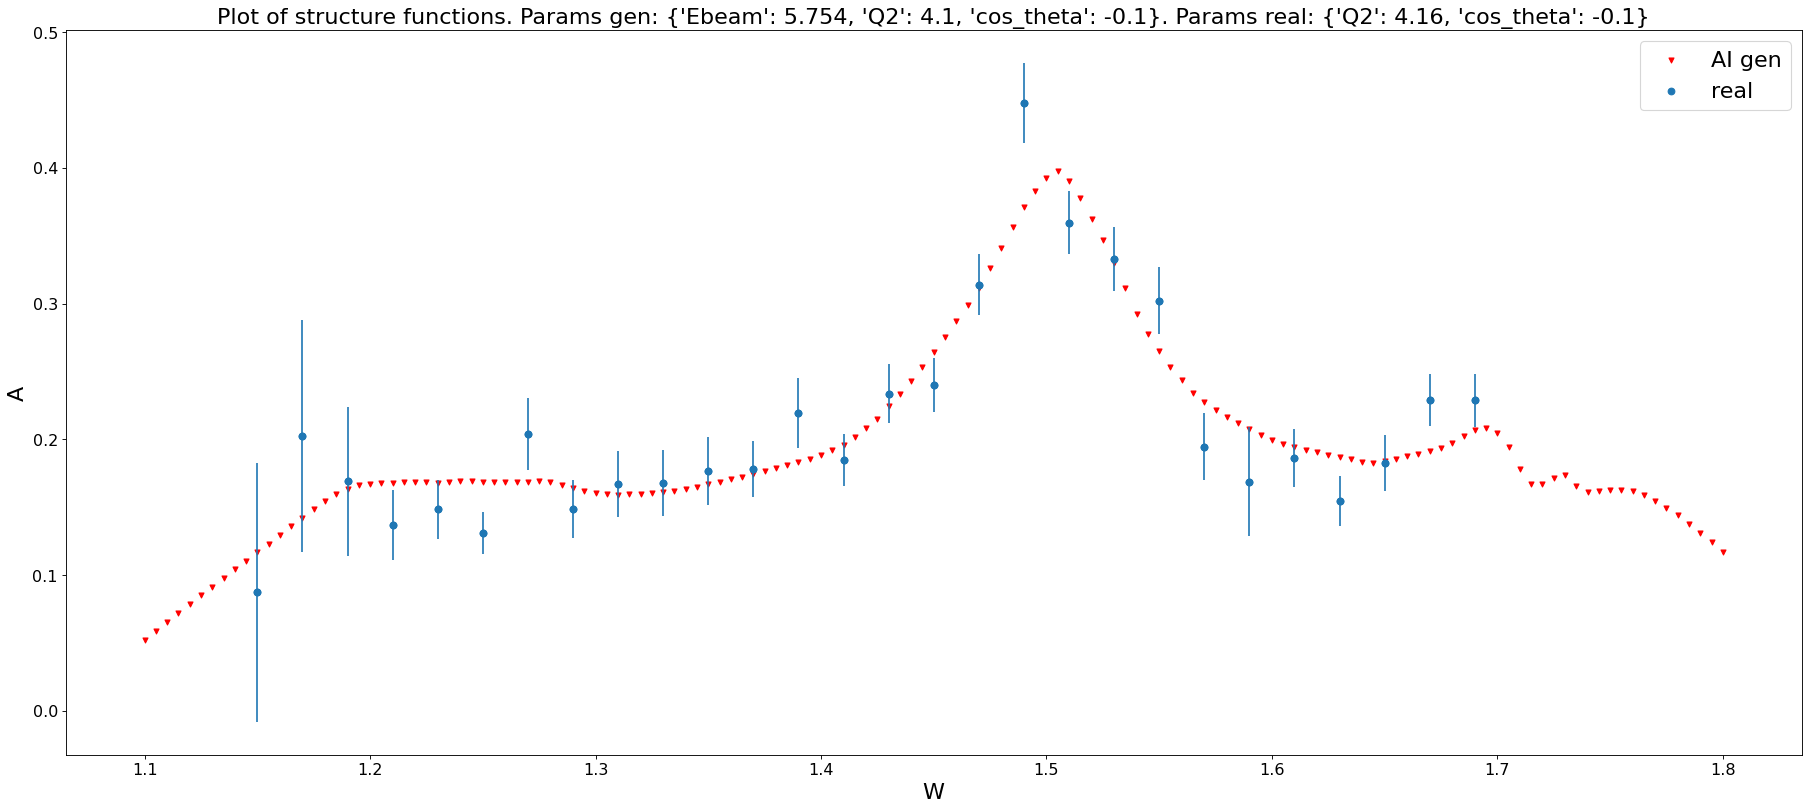

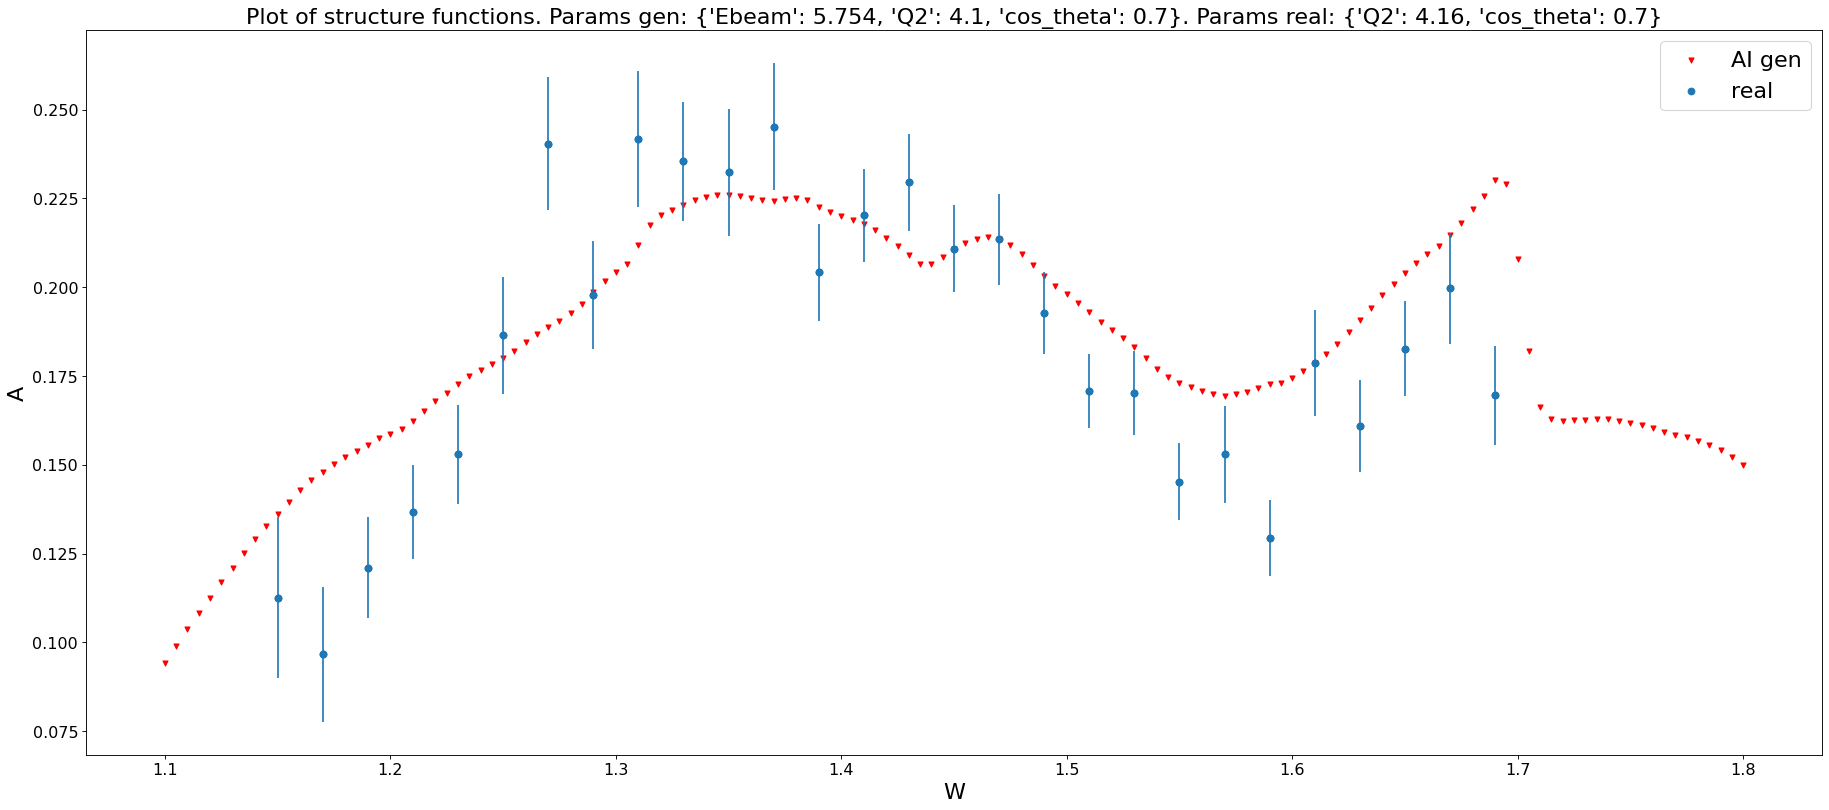

In [121]:
for i in range(3):
    for j in range(3):
        params_gen = {'Ebeam' : Ebeam,
                    'Q2' : Q2_gen[i],
                    'cos_theta' : cos_theta_gen[j]}

        params_real = {'Q2' : Q2_real[i],
                       'cos_theta' : cos_theta_real[j]}
        plot_gen_real_almaz(params_gen, params_real)

In [125]:
gen_ABC_W(5.754, 2.2, 0.5)

,Ebeam,W,Q2,cos_theta,A,B,C
17766,5.754,1.100,2.2,0.5,0.234336,-0.014318,-0.033740
91854,5.754,1.105,2.2,0.5,0.242512,-0.016025,-0.033270
165942,5.754,1.110,2.2,0.5,0.253795,-0.023097,-0.033975
240030,5.754,1.115,2.2,0.5,0.269273,-0.035566,-0.033392
314118,5.754,1.120,2.2,0.5,0.288287,-0.051699,-0.031544
...,...,...,...,...,...,...,...
10093734,5.754,1.780,2.2,0.5,0.508994,-0.123609,0.063169
10167822,5.754,1.785,2.2,0.5,0.503405,-0.114836,0.064054
10241910,5.754,1.790,2.2,0.5,0.497798,-0.107341,0.064044
10315998,5.754,1.795,2.2,0.5,0.492284,-0.101685,0.064147


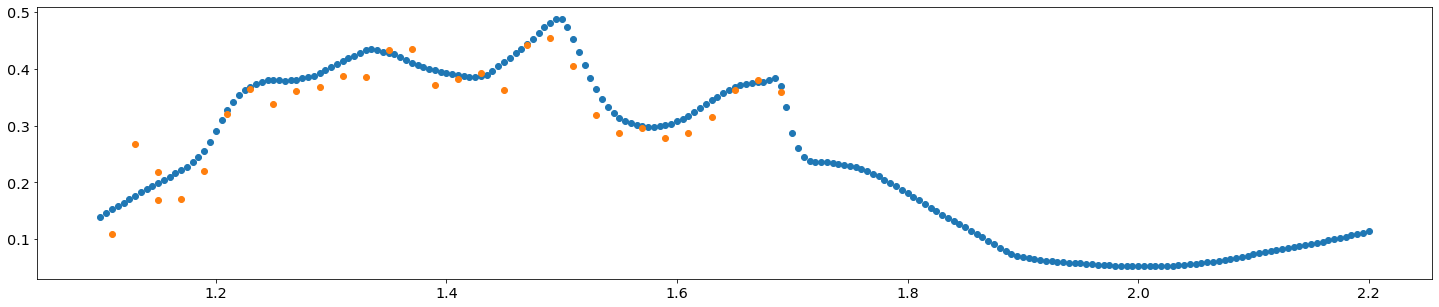

In [144]:
plt.scatter(gen_ABC_W(5.754, 3.5, 0.5).W, gen_ABC_W(5.754, 3.5, 0.5).A)
plt.scatter(df_a[(df_a.Q2 == 3.48)& (df_a.cos_theta==0.500)].W, df_a[(df_a.Q2 == 3.48)& (df_a.cos_theta==0.500)].sigma_t)


In [155]:
Ebeam = 5.754
Q2_gen = [1.7, 2.9, 4.1]
Q2_real = [1.72, 2.91, 4.155]

<AxesSubplot:>

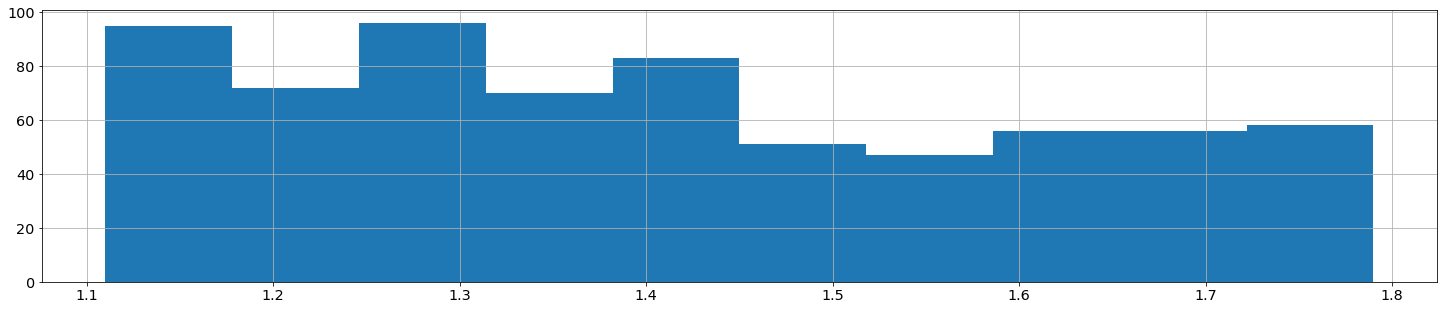

In [161]:
df[(df.Ebeam == 5.754)&
   (df.Q2 == 1.715)&
   (df.cos_theta==0.7)].W.hist()

# Overlapping

In [97]:
df_a.cos_theta.unique()

array([-0.608761,  0.991445,  0.92388 ,  0.793353,  0.608761,  0.382683,
        0.130526, -0.130526, -0.382683, -0.793353, -0.92388 ,  0.3     ,
        0.5     ,  0.7     ,  0.9     , -0.3     , -0.1     ,  0.1     ,
       -0.5     , -0.7     , -0.9     ,  0.725   ,  0.525   ,  0.575   ,
        0.675   ,  0.875   ,  0.625   ,  0.775   ,  0.825   ,  0.925   ,
        0.975   ])

In [125]:
cos = -0.7
df_tmp_spec = df_a[(df_a.Q2 == 1.72)&(df_a.cos_theta == cos)]
W_1 = df_tmp_spec.W
A_1 = df_tmp_spec.sigma_t + df_tmp_spec.sigma_l
A_d_1 = df_tmp_spec.d_sigma_t + df_tmp_spec.d_sigma_l

df_tmp_spec = df_a[(df_a.Q2 == 1.8)&(df_a.cos_theta == cos)]
W_2 = df_tmp_spec.W
A_2 = df_tmp_spec.sigma_t + df_tmp_spec.sigma_l
A_d_2 = df_tmp_spec.d_sigma_t + df_tmp_spec.d_sigma_l

df_gen = gen_ABC_W(5.754, 1.8, cos)
df_gen = df_gen[(df_gen.W < max(W_2))&(df_gen.W >=min(W_1))]
W_gen = df_gen.W
A_gen = df_gen.A

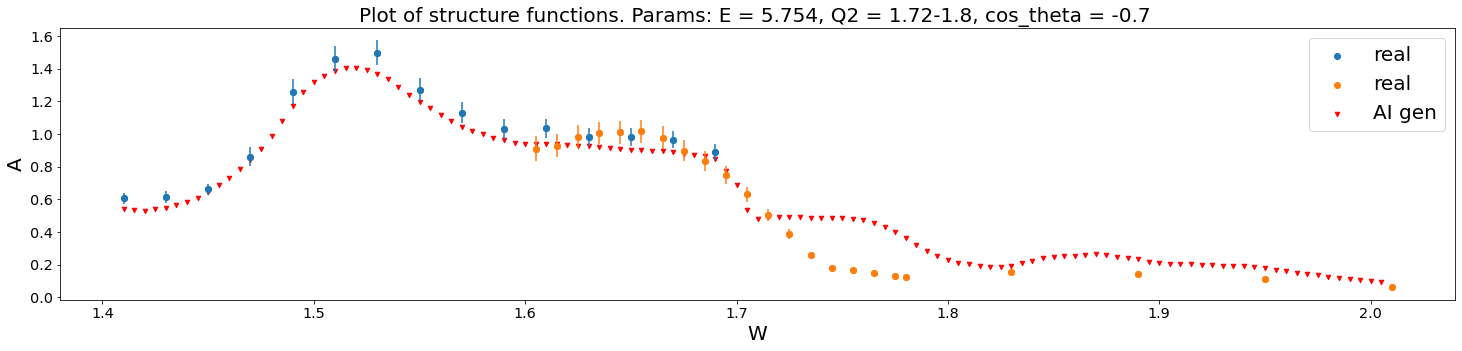

In [126]:
plt.scatter(W_1, A_1, label= 'real')
plt.errorbar(W_1, A_1, yerr=A_d_1, fmt='o')

plt.scatter(W_2, A_2, label= 'real')
plt.errorbar(W_2, A_2, yerr=A_d_2, fmt='o')

plt.scatter(df_gen.W, df_gen.A, label= 'AI gen', color='red', s=20, marker='v')

plt.xlabel("W", fontsize=20)
plt.ylabel("A", fontsize=20)
plt.title(f'Plot of structure functions. Params: E = {5.754}, Q2 = 1.72-1.8, cos_theta = {cos} ', fontsize=20)
plt.legend(fontsize=20)